avrora, fop, jython, luindex,
lusearch, lusearch-fix, pmd and xalan

https://bergel.eu/MyPapers/Cana21a-JVMGlagsAndGA.pdf

In [1]:
! export WANDB_NOTEBOOK_NAME="main.ipynb"
import wandb

PROJECT_NAME = "Reinforcement Learning (DQN) - JVM-GC"
WANDB_KEY = "4b077df3688052b0f43705d6b4d712c05fb979b7"
config = dict(
    competition = PROJECT_NAME,
    _wandb_kernel = 'lemon',
    seed = 42,
)

In [2]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(filename="gc-ml-ppo.log",
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s')


logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# logger.setLevel(logging.INFO)
# logger.error("test")

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from tf_agents.agents import PPOAgent
from tf_agents.environments import tf_py_environment, BatchedPyEnvironment
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy, policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import tensor_spec, from_spec
from tf_agents import trajectories
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork
from tf_agents.networks.value_network import ValueNetwork
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver


# from env.PyEnvironments import CurveEnv, CurveMultipleEnv, JVMEnv
# from env.PyEnvironments import JVMEnv
from env.PyEnvironmentsTest import JVMEnv # !!!
from util.plots_util import plot_dataset, plot_goal_heatmap

tf.random.set_seed(42)
np.random.seed(42) 

In [4]:
dataset_path = "dataset/data"
tempdir = "tmp"
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
policy_dir = os.path.join(tempdir, 'policy')

env_args = {
    "jdk_path": "jdk-11.0.20.1.jdk",
    "bm_path": "dacapo-bench.jar",
    "gc_viewer_jar": "gcviewer-1.36.jar",
    "callback_path": "callback/VMStatCallback.java",
    "n": 5,
    "goal": "avgGCPause",
    "verbose": False,
}

def get_tf_env(name, args):
    env = JVMEnv(bm_name=name, **args)
    tf_env = tf_py_environment.TFPyEnvironment(env, isolation=True) 
    return tf_env


# Batch together multiple py environments and act as a single batch.
names = ["ext_kafka_2", "ext_kafka_4", "ext_kafka_8", "ext_kafka_16", "ext_kafka_32",
         "ext_avrora_2", "ext_avrora_4", "ext_avrora_8", "ext_avrora_16", "ext_avrora_32"]

envs = [JVMEnv(bm_name=name, **env_args) for name in names]

batched_env = BatchedPyEnvironment(envs)
train_env = tf_py_environment.TFPyEnvironment(batched_env)

test_env = get_tf_env(name="ext_h2", args=env_args)

action_spec = from_spec(train_env.action_spec())
observation_spec = from_spec(train_env.observation_spec())
reward_spec = from_spec(train_env.reward_spec())
time_step_spec = trajectories.time_step_spec(observation_spec, reward_spec)

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: ext_kafka_2 (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16, 'step': 3}, 'ParallelGCThreads': {'min': 4, 'max': 24, 'step': 4}},
 Env. default state: [1, 20, 0.00875, 6103.25, 71.522, 49.4, 833.0, 672.272, 102.1, 190.824],
 Env. default goal value: 0.00875,

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: ext_kafka_4 (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16, 'step': 3}, 'ParallelGCThreads': {'min': 4, 'max': 24, 'step': 4}},
 Env. default state: [4, 4, 0.00994, 7444.8, 36.352, 63.6, 1503.0, 1345.0, 99.3, 172.963],
 Env. default goal value: 0.00994,

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: ext_kafka_8 (dacapo-be

In [5]:
def get_q_net(action_spec, fc_layer_params = (100, 75, 50)):
    action_tensor_spec = tensor_spec.from_spec(action_spec)
    num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

    def dense_layer(num_units):
        """
        Define a helper function to create Dense layers configured 
        with the right activation and kernel initializer.
        """
        return tf.keras.layers.Dense(
            num_units,
            activation=tf.keras.activations.relu,
            kernel_initializer=tf.keras.initializers.VarianceScaling(
                scale=2.0, mode='fan_in', distribution='truncated_normal'))

    # QNetwork consists of a sequence of Dense layers followed by a dense layer
    # with `num_actions` units to generate one q_value per available action as
    # its output.
    dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.RandomUniform(
            minval=-0.03, maxval=0.03),
        bias_initializer=tf.keras.initializers.Constant(-0.2))
    q_net = sequential.Sequential(dense_layers + [q_values_layer])
    return q_net

def collect_step(environment, policy, replay_buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)

    next_time_step = environment.step(action_step.action)
    # reward = next_time_step.reward
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    return traj

def save_dataset(data, path):
    step_counter = tf.Variable(0, trainable=False)
    checkpoint_prefix = "checkpoint"
    checkpoint_args = {
        "checkpoint_interval": 50,
        "step_counter": step_counter,
        "directory": checkpoint_prefix,
        "max_to_keep": 3,
    }
    try:
        data.save(path, checkpoint_args=checkpoint_args)
    except:
        pass

def save_rb(replay_buffer, path):
    tf.train.Checkpoint(rb = replay_buffer).save(path)

def restore_rb(replay_buffer, path):
    tf.train.Checkpoint(rb = replay_buffer).restore(path)

def get_dataset(
    replay_buffer, 
    size, 
    batch_size, 
    collect_data_spec, 
    n_step_update, 
    create: bool = True, 
    save: bool = False):
    
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=collect_data_spec, # agent.collect_data_spec
        batch_size=1, # train_env.batch_size
        max_length=size) # capacity

    if create:
        for _ in tqdm(range(size)):
            traj = collect_step(train_env, random_policy, replay_buffer)
            replay_buffer.add_batch(traj)

        if save: save_rb(replay_buffer, dataset_path)
    else: 
        restore_rb(replay_buffer, dataset_path+'-1')

    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3, 
        sample_batch_size=batch_size,
        num_steps=n_step_update + 1, 
        single_deterministic_pass=False).prefetch(3)
    # iterator = iter(dataset)
    return dataset
    
def compute_avg_return(environment, policy, num_episodes=50):
    """
    Computes the average return of a policy, 
    given the policy, environment, and a number of episodes.

    Note: for non-episodic tasks.
    """
    total_return = 0.0
    time_step = environment.reset()
    for _ in tqdm(range(num_episodes)):
        action_step = policy.action(time_step, seed=42)
        time_step = environment.step(action_step.action)
        total_return += time_step.reward

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def get_env_state(environment):
    return environment.current_time_step().observation.numpy().squeeze()[:3]

def compute_avg_return_episodic(
    environment, policy, num_episodes=10, patience=100,
    print_info=False):
    """
    Computes the average return of a policy, 
    given the policy, environment, and a number of episodes.

    Note: for episodic tasks.
    """
    total_return = 0.0
    environment.reset()
    # default_state = get_env_state(environment)
    
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        i = 0
        while not time_step.is_last():
            if i >= patience:
                break
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            obs = time_step.observation.numpy()[0]
            rwd = time_step.reward.numpy()[0]
            episode_return += time_step.reward
            i += 1
        total_return += episode_return / i
    
    # if print_info: print("default:", default_state, "current:", get_env_state(environment))
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def create_networks(observation_spec, action_spec, fc_layer_params):
    actor_net = ActorDistributionNetwork(
            observation_spec, # input
            action_spec, # output
            fc_layer_params=fc_layer_params,
            activation_fn=tf.keras.activations.tanh)
    
    value_net = ValueNetwork(
            observation_spec, # input
            fc_layer_params=fc_layer_params,
            activation_fn=tf.keras.activations.tanh)

    return actor_net, value_net

def plot_training(loss, rewards, num_steps, eval_interval):
    fig, ax1 = plt.subplots()

    steps = [step for step in range(0, num_steps, eval_interval)]
    color = 'tab:red'
    ax1.set_xlabel('steps')
    ax1.set_ylabel('loss', color=color)
    ax1.plot(steps, loss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('rewards', color=color)  # we already handled the x-label with ax1
    ax2.plot(steps, rewards[:200], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [8]:
def get_dataset_iter(envs, size, _agent, _train_episodes_per_iteration):
    """Get a dataset iterator with trajectories
    collected from environments from list `envs`
    using `_agent` collect policy. 

    Args:
        envs (list(PyEnvironment)): List of PyEnvironments 
        to collect data from.
        size (int):   A dataset size (number of trajectories
        to collect.)
        _agent (_type_): A Tensorflow Agent.
        _train_episodes_per_iteration (int): 
            A number of trajectories per batch.

    Returns:
        iterator: A dataset iterator.
    """
    from random import randrange
    assert len(envs) >= 1, "Environment list is empty!"
    num_iterations_to_reset = 50
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=_agent.collect_data_spec, # agent.collect_data_spec
        batch_size=envs[0].batch_size, # train_env.batch_size
        max_length=size) # capacity
    
    i = 0
    for _ in tqdm(range(size)):
        # Select a random environment from list.
        indx = randrange(len(envs)) 
        env = envs[indx]
        
        if i >= num_iterations_to_reset:
            env.reset()
            
        traj = collect_step(env, _agent.collect_policy, replay_buffer)
        replay_buffer.add_batch(traj)
        i += 1
            
    dataset = replay_buffer.as_dataset(
        sample_batch_size=batch_size,
        num_steps=train_episodes_per_iteration+1,
        num_parallel_calls=_train_episodes_per_iteration).prefetch(_train_episodes_per_iteration)
    dataset_iter = iter(dataset)
    return dataset_iter

In [7]:
collect_steps_per_iteration = 1
dataset_size = 10000
# fc_layer_params = (100, 75, 50)
# fc_layer_params = (200, 100)
# fc_layer_params = (128, 128, 128)
fc_layer_params = (200, 150, 100, 75, 50)

batch_size = 24
learning_rate = 1e-3
# learning_rate = 0.0005

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}

# train_episodes_per_iteration = 10
train_episodes_per_iteration = 5
n_step_update = 4
actor_net, value_net = create_networks(observation_spec, action_spec, fc_layer_params)
global_step = tf.compat.v1.train.get_or_create_global_step()

agent_args = {
    "optimizer": tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate),
    "actor_net": actor_net,
    "value_net": value_net,
    "train_step_counter": global_step,
    # "train_step_counter": global_step,
    # "importance_ratio_clipping": 0.1,
    # "num_epochs": 20,
    "entropy_regularization": 0.01,
}

In [8]:
agent = PPOAgent(
  time_step_spec,
  action_spec,
  **agent_args
)

agent.initialize()
agent.train = common.function(agent.train, autograph=False)

random_policy = random_tf_policy.RandomTFPolicy(
  time_step_spec = time_step_spec,
  action_spec = action_spec,
  automatic_state_reset=True,
  clip=False,
  emit_log_probability=True
)

def get_cd_and_rb(_env, _agent, size, n_steps):
  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
      data_spec=_agent.collect_data_spec, # agent.collect_data_spec
      batch_size=_env.batch_size, # train_env.batch_size
      max_length=size) # capacity

  replay_buffer_observer = replay_buffer.add_batch

  collect_driver = DynamicEpisodeDriver(
      _env,
      _agent.collect_policy,
      observers=[replay_buffer_observer], # + train_metrics,
      num_episodes=n_steps)
  
  return collect_driver, replay_buffer


In [9]:
policy_dir = os.path.join(tempdir, '0_policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

## Agent Training

In [10]:
def train(_agent, _env_train, _env_val, 
          collect_driver, 
          replay_buffer, 
          steps: int = 5000, 
          use_wandb: bool = False,
          eval_interval: int=100):
    """
    Train reinforcement learning agent and evaluate
    performance on a separate environment.
    """
    
    _env_train.reset()
    _env_val.reset()
    _agent.train_step_counter.assign(0)
    _agent.train = common.function(_agent.train)
    time_step = None
    policy_state = _agent.collect_policy.get_initial_state(_env_train.batch_size)

    loss = []
    observations = []
    rewards = []
    for step in tqdm(range(steps)):
        
        time_step, policy_state = collect_driver.run(
            time_step=time_step,
            policy_state=policy_state,
            maximum_iterations=50,
        )

        experience = replay_buffer.gather_all()
        train_loss = _agent.train(experience)
        replay_buffer.clear()
        
        if step % eval_interval == 0:
            avg_reward = compute_avg_return_episodic(_env_val, _agent.policy, num_episodes=20)

            loss.append(train_loss.loss.numpy())
            # observations.append(obs)
            rewards.append(avg_reward)

            # wandb logger for tuning hyperparameters
            if use_wandb:
                wandb.log({'loss': train_loss.loss, 'reward': avg_reward})

            print(f"step = {step}: loss = {train_loss.loss}, reward = {avg_reward}")
    return loss, observations, rewards

def _train(_agent, _env_train, _env_val, data_iterator,
          steps: int = 5000, 
          use_wandb: bool = False,
          eval_interval: int=100):
    """
    Train reinforcement learning agent and evaluate
    performance on a separate environment.
    """
    
    _env_train.reset()
    _env_val.reset()
    _agent.train_step_counter.assign(0)
    _agent.train = common.function(_agent.train)
    
    time_step = None
    policy_state = _agent.collect_policy.get_initial_state(_env_train.batch_size)

    loss = []
    observations = []
    rewards = []
    for step in tqdm(range(steps)):
        
        experience, _ = next(data_iterator)
        train_loss = _agent.train(experience)
        
        if step % eval_interval == 0:
            avg_reward = compute_avg_return_episodic(_env_val, _agent.policy, num_episodes=20)

            loss.append(train_loss.loss.numpy())
            # observations.append(obs)
            rewards.append(avg_reward)

            # wandb logger for tuning hyperparameters
            if use_wandb:
                wandb.log({'loss': train_loss.loss, 'reward': avg_reward})

            print(f"step = {step}: loss = {train_loss.loss}, reward = {avg_reward}")
    
    return loss, observations, rewards

### Train Sequentially

In [11]:
num_steps = 5000

train_env_copy = get_tf_env("avrora", env_args)

train_env_2 = get_tf_env("kafka", env_args)
train_env_2_copy = get_tf_env("kafka", env_args)

# test_env = get_tf_env("test", env_args)
# test_env_copy = get_tf_env("test", env_args)

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: avrora (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16, 'step': 3}, 'ParallelGCThreads': {'min': 4, 'max': 24, 'step': 4}},
 Env. default state: [4, 4, 0.00742, 0.5562328093236883, 0.5562237530356411, 0.028735632183908, 0.028395061728395, 0.0292283662759177, 0.0294695481335953, 0.9816754502341878],
 Env. default goal value: 0.00742,

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: kafka (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16, 'step': 3}, 'ParallelGCThreads': {'min': 4, 'max': 24, 'step': 4}},
 Env. default state: [10, 12, 0.02917, 0.9999989364615453, 0.9999985132665884, 0.9252873563218392, 0.928395061728395, 0.9263209260597306, 0.925343811394892, 2.3067

In [13]:
# Train on first
collect_driver, replay_buffer = get_cd_and_rb(train_env, agent)
loss, observations, rewards = train(
    agent, train_env, train_env_copy, collect_driver, replay_buffer, steps = num_steps, eval_interval=100)

print("AVG RETURN - KAFKA:", 
      compute_avg_return_episodic(train_env_2, agent.policy, num_episodes=50))

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 1/5000 [00:28<39:46:25, 28.64s/it]

step = 0: loss = 28.902631759643555, reward = 0.009563921019434929


  2%|▏         | 101/5000 [01:19<5:27:18,  4.01s/it]

step = 100: loss = -0.12217696011066437, reward = 0.10741065442562103


  4%|▍         | 201/5000 [02:11<5:17:22,  3.97s/it]

step = 200: loss = -0.12155486643314362, reward = -0.054414473474025726


  6%|▌         | 301/5000 [03:05<5:19:49,  4.08s/it]

step = 300: loss = -0.14047378301620483, reward = -0.1808028370141983


  8%|▊         | 401/5000 [03:55<4:51:41,  3.81s/it]

step = 400: loss = -0.12208157032728195, reward = 0.13025769591331482


 10%|█         | 501/5000 [04:46<4:57:33,  3.97s/it]

step = 500: loss = -0.12516961991786957, reward = -0.047113142907619476


 12%|█▏        | 601/5000 [05:40<4:58:12,  4.07s/it]

step = 600: loss = -0.13263054192066193, reward = 0.023856637999415398


 14%|█▍        | 701/5000 [06:31<4:36:40,  3.86s/it]

step = 700: loss = -0.12135445326566696, reward = -0.09978403896093369


 16%|█▌        | 801/5000 [07:22<4:32:15,  3.89s/it]

step = 800: loss = -0.12417945265769958, reward = -0.12913194298744202


 18%|█▊        | 901/5000 [08:13<4:21:34,  3.83s/it]

step = 900: loss = -0.12012037634849548, reward = -0.0812155231833458


 20%|██        | 1001/5000 [09:06<4:55:30,  4.43s/it]

step = 1000: loss = -0.12780579924583435, reward = 0.04057605192065239


 22%|██▏       | 1101/5000 [09:57<4:17:19,  3.96s/it]

step = 1100: loss = -0.15671901404857635, reward = -0.04562435299158096


 24%|██▍       | 1201/5000 [10:53<4:18:10,  4.08s/it]

step = 1200: loss = -0.12041907012462616, reward = 0.04573701694607735


 26%|██▌       | 1301/5000 [11:46<4:03:05,  3.94s/it]

step = 1300: loss = -0.11761971563100815, reward = -0.0033242765348404646


 28%|██▊       | 1401/5000 [12:39<3:53:54,  3.90s/it]

step = 1400: loss = -0.11471748352050781, reward = 0.0010996530763804913


 30%|███       | 1501/5000 [13:38<5:33:23,  5.72s/it]

step = 1500: loss = -0.11971862614154816, reward = -0.04055100679397583


 32%|███▏      | 1601/5000 [14:42<5:44:22,  6.08s/it]

step = 1600: loss = -0.11644572764635086, reward = -0.15625840425491333


 34%|███▍      | 1701/5000 [15:34<3:33:43,  3.89s/it]

step = 1700: loss = -0.11681109666824341, reward = -0.21186129748821259


 36%|███▌      | 1801/5000 [16:26<3:33:53,  4.01s/it]

step = 1800: loss = -0.1096460372209549, reward = -0.12031445652246475


 38%|███▊      | 1901/5000 [17:18<3:20:41,  3.89s/it]

step = 1900: loss = -0.07287707179784775, reward = -0.1658892035484314


 40%|████      | 2001/5000 [18:16<4:03:25,  4.87s/it]

step = 2000: loss = -0.11350805312395096, reward = -0.08294306695461273


 42%|████▏     | 2101/5000 [19:07<3:02:34,  3.78s/it]

step = 2100: loss = -0.11182614415884018, reward = -0.20583422482013702


 44%|████▍     | 2201/5000 [19:57<2:56:22,  3.78s/it]

step = 2200: loss = -0.11087335646152496, reward = -0.12639972567558289


 46%|████▌     | 2301/5000 [20:49<3:13:17,  4.30s/it]

step = 2300: loss = -0.09479192644357681, reward = -0.05476980656385422


 48%|████▊     | 2401/5000 [21:41<2:54:56,  4.04s/it]

step = 2400: loss = -0.0014683204935863614, reward = -0.16155274212360382


 50%|█████     | 2501/5000 [22:37<3:08:39,  4.53s/it]

step = 2500: loss = -0.03699420019984245, reward = -0.20467133820056915


 52%|█████▏    | 2601/5000 [23:29<2:36:24,  3.91s/it]

step = 2600: loss = -0.10927896946668625, reward = -0.31928008794784546


 54%|█████▍    | 2701/5000 [24:19<2:24:42,  3.78s/it]

step = 2700: loss = -0.10431338846683502, reward = -0.15599094331264496


 56%|█████▌    | 2801/5000 [25:09<2:18:55,  3.79s/it]

step = 2800: loss = -0.11629707366228104, reward = -0.24302449822425842


 58%|█████▊    | 2901/5000 [26:01<2:17:37,  3.93s/it]

step = 2900: loss = -0.09800298511981964, reward = -0.4591086804866791


 60%|██████    | 3001/5000 [26:51<2:09:36,  3.89s/it]

step = 3000: loss = -0.10718017816543579, reward = -0.2882995009422302


 62%|██████▏   | 3101/5000 [27:41<1:59:01,  3.76s/it]

step = 3100: loss = -0.10472153127193451, reward = -0.29563093185424805


 64%|██████▍   | 3201/5000 [28:37<2:20:58,  4.70s/it]

step = 3200: loss = -0.11518708616495132, reward = -0.15007063746452332


 66%|██████▌   | 3301/5000 [29:41<2:15:06,  4.77s/it]

step = 3300: loss = -0.08996358513832092, reward = -0.20825421810150146


 68%|██████▊   | 3401/5000 [30:35<1:42:30,  3.85s/it]

step = 3400: loss = -0.06932719796895981, reward = -0.09602121263742447


 70%|███████   | 3501/5000 [31:26<1:35:16,  3.81s/it]

step = 3500: loss = 0.08029784262180328, reward = -0.14908118546009064


 72%|███████▏  | 3601/5000 [32:17<1:31:52,  3.94s/it]

step = 3600: loss = -0.10365701466798782, reward = -0.21505753695964813


 74%|███████▍  | 3701/5000 [33:07<1:23:31,  3.86s/it]

step = 3700: loss = -0.09262917190790176, reward = -0.19250598549842834


 76%|███████▌  | 3801/5000 [33:57<1:16:11,  3.81s/it]

step = 3800: loss = -0.09590969979763031, reward = -0.17102284729480743


 78%|███████▊  | 3901/5000 [34:47<1:11:16,  3.89s/it]

step = 3900: loss = -0.09566880762577057, reward = -0.2066037952899933


 80%|████████  | 4001/5000 [35:37<1:02:21,  3.75s/it]

step = 4000: loss = -0.09816298633813858, reward = -0.24682223796844482


 82%|████████▏ | 4101/5000 [36:29<57:54,  3.86s/it]

step = 4100: loss = -0.10664721578359604, reward = -0.08116856217384338


 84%|████████▍ | 4201/5000 [37:21<51:33,  3.87s/it]

step = 4200: loss = -0.07868582010269165, reward = -0.04766662418842316


 86%|████████▌ | 4301/5000 [38:15<52:52,  4.54s/it]

step = 4300: loss = -0.07521019876003265, reward = -0.09636393934488297


 88%|████████▊ | 4401/5000 [39:07<40:02,  4.01s/it]

step = 4400: loss = -0.10130394250154495, reward = -0.1365879327058792


 90%|█████████ | 4501/5000 [39:59<32:47,  3.94s/it]

step = 4500: loss = -0.10128697752952576, reward = -0.011847374960780144


 92%|█████████▏| 4601/5000 [40:49<25:52,  3.89s/it]

step = 4600: loss = -0.10102717578411102, reward = -0.12869268655776978


 94%|█████████▍| 4701/5000 [41:42<19:20,  3.88s/it]

step = 4700: loss = -0.10895377397537231, reward = 0.032198309898376465


 96%|█████████▌| 4801/5000 [42:33<13:27,  4.06s/it]

step = 4800: loss = -0.10902483761310577, reward = -0.06275109946727753


 98%|█████████▊| 4901/5000 [43:26<06:18,  3.82s/it]

step = 4900: loss = -0.12051510065793991, reward = -0.05913602560758591


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]

AVG RETURN - KAFKA: 0.0030280044


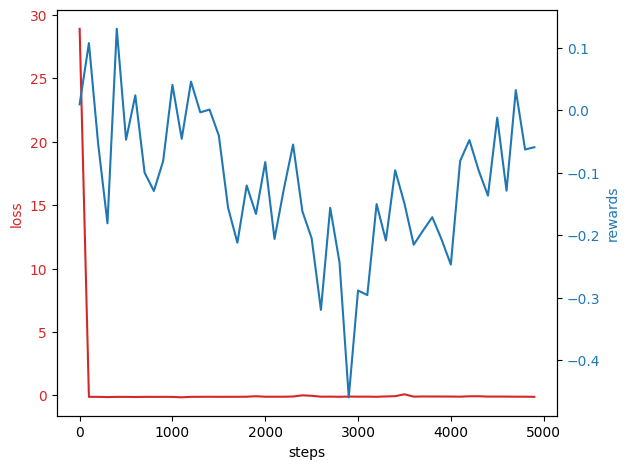

In [14]:
plot_training(loss, rewards, num_steps, 100)

In [15]:
loss, observations, rewards = train(
    agent, train_env, train_env_copy, collect_driver, replay_buffer, steps = num_steps, eval_interval=100)


  0%|          | 1/5000 [00:18<26:03:03, 18.76s/it]

step = 0: loss = 2.3935961723327637, reward = -0.08524542301893234


  2%|▏         | 101/5000 [01:09<5:17:43,  3.89s/it]

step = 100: loss = -0.12164812535047531, reward = -0.09026005119085312


  4%|▍         | 201/5000 [01:59<5:08:48,  3.86s/it]

step = 200: loss = -0.12125816941261292, reward = -0.02092362567782402


  6%|▌         | 301/5000 [02:51<5:02:07,  3.86s/it]

step = 300: loss = -0.12100689858198166, reward = -0.019010009244084358


  8%|▊         | 401/5000 [03:42<5:07:32,  4.01s/it]

step = 400: loss = -0.12203968316316605, reward = -0.1057734340429306


 10%|█         | 501/5000 [04:35<5:10:42,  4.14s/it]

step = 500: loss = 0.5449185967445374, reward = 0.20654818415641785


 12%|█▏        | 601/5000 [05:27<4:42:49,  3.86s/it]

step = 600: loss = 0.12020786851644516, reward = -0.08972353488206863


 14%|█▍        | 701/5000 [06:17<4:36:43,  3.86s/it]

step = 700: loss = 0.1178484857082367, reward = 0.04620600491762161


 16%|█▌        | 801/5000 [07:09<4:44:21,  4.06s/it]

step = 800: loss = 0.11423169821500778, reward = 0.05797123908996582


 18%|█▊        | 901/5000 [08:09<5:00:31,  4.40s/it]

step = 900: loss = 0.11202795803546906, reward = 0.08857231587171555


 20%|██        | 1001/5000 [09:05<4:46:14,  4.29s/it]

step = 1000: loss = 0.1183023676276207, reward = 0.06645048409700394


 22%|██▏       | 1101/5000 [10:26<10:29:55,  9.69s/it]

step = 1100: loss = 0.11778132617473602, reward = 0.084475576877594


 24%|██▍       | 1201/5000 [11:28<4:33:47,  4.32s/it]

step = 1200: loss = 0.11349839717149734, reward = 0.23287606239318848


 26%|██▌       | 1301/5000 [12:21<4:08:57,  4.04s/it]

step = 1300: loss = 0.09798666089773178, reward = 0.15252044796943665


 28%|██▊       | 1401/5000 [13:14<3:51:58,  3.87s/it]

step = 1400: loss = 0.10044006258249283, reward = 0.2212250679731369


 30%|███       | 1501/5000 [14:09<3:53:43,  4.01s/it]

step = 1500: loss = 0.08438204228878021, reward = 0.21633855998516083


 32%|███▏      | 1601/5000 [15:05<4:49:45,  5.11s/it]

step = 1600: loss = 0.06959390640258789, reward = 0.2215852439403534


 34%|███▍      | 1701/5000 [15:59<3:39:43,  4.00s/it]

step = 1700: loss = 0.07805465906858444, reward = 0.2126867026090622


 36%|███▌      | 1801/5000 [16:50<3:21:09,  3.77s/it]

step = 1800: loss = 0.11215945333242416, reward = 0.13990293443202972


 38%|███▊      | 1901/5000 [17:42<3:25:01,  3.97s/it]

step = 1900: loss = 0.1106598749756813, reward = 0.24889183044433594


 40%|████      | 2001/5000 [18:31<3:10:37,  3.81s/it]

step = 2000: loss = 0.07175104320049286, reward = 0.22520026564598083


 42%|████▏     | 2101/5000 [19:21<3:05:44,  3.84s/it]

step = 2100: loss = 0.05647712200880051, reward = 0.2317294329404831


 44%|████▍     | 2201/5000 [20:11<2:56:22,  3.78s/it]

step = 2200: loss = -0.12164752930402756, reward = 0.2467513382434845


 46%|████▌     | 2301/5000 [21:01<2:50:55,  3.80s/it]

step = 2300: loss = 0.05813376232981682, reward = 0.2371426820755005


 48%|████▊     | 2401/5000 [21:50<2:46:00,  3.83s/it]

step = 2400: loss = 0.10486495494842529, reward = 0.28368085622787476


 50%|█████     | 2501/5000 [22:40<2:39:08,  3.82s/it]

step = 2500: loss = 0.10581547021865845, reward = 0.21570351719856262


 52%|█████▏    | 2601/5000 [23:30<2:34:59,  3.88s/it]

step = 2600: loss = 0.03669300675392151, reward = 0.2747664451599121


 54%|█████▍    | 2701/5000 [24:20<2:26:09,  3.81s/it]

step = 2700: loss = 0.049320586025714874, reward = 0.26521965861320496


 56%|█████▌    | 2801/5000 [25:10<2:23:52,  3.93s/it]

step = 2800: loss = 0.10751616209745407, reward = 0.03046208620071411


 58%|█████▊    | 2901/5000 [26:00<2:12:47,  3.80s/it]

step = 2900: loss = 0.028574436902999878, reward = -0.078873410820961


 60%|██████    | 3001/5000 [26:49<2:06:03,  3.78s/it]

step = 3000: loss = 0.11305896937847137, reward = -0.0822506695985794


 62%|██████▏   | 3101/5000 [27:39<2:02:51,  3.88s/it]

step = 3100: loss = 0.10693422704935074, reward = -0.13296742737293243


 64%|██████▍   | 3201/5000 [28:29<1:53:45,  3.79s/it]

step = 3200: loss = 0.1026078313589096, reward = -0.054457150399684906


 66%|██████▌   | 3301/5000 [29:21<1:50:31,  3.90s/it]

step = 3300: loss = 0.09237673878669739, reward = -0.13591960072517395


 68%|██████▊   | 3401/5000 [30:11<1:42:14,  3.84s/it]

step = 3400: loss = 0.10058660060167313, reward = -0.06709173321723938


 70%|███████   | 3501/5000 [31:00<1:34:43,  3.79s/it]

step = 3500: loss = 0.0451681949198246, reward = -0.06473610550165176


 72%|███████▏  | 3601/5000 [31:50<1:30:36,  3.89s/it]

step = 3600: loss = 0.11888808757066727, reward = -0.14535395801067352


 74%|███████▍  | 3701/5000 [32:40<1:22:02,  3.79s/it]

step = 3700: loss = 0.022169478237628937, reward = -0.06088108569383621


 76%|███████▌  | 3801/5000 [33:30<1:15:42,  3.79s/it]

step = 3800: loss = -0.11868000030517578, reward = -0.07580452412366867


 78%|███████▊  | 3901/5000 [34:20<1:09:30,  3.79s/it]

step = 3900: loss = -0.10230109095573425, reward = -0.07970742881298065


 80%|████████  | 4001/5000 [35:10<1:04:59,  3.90s/it]

step = 4000: loss = 0.07089538872241974, reward = -0.0261381808668375


 82%|████████▏ | 4101/5000 [36:00<56:37,  3.78s/it]

step = 4100: loss = -0.022438040003180504, reward = -0.09630493819713593


 84%|████████▍ | 4201/5000 [36:50<50:22,  3.78s/it]

step = 4200: loss = 0.07430949807167053, reward = -0.061931073665618896


 86%|████████▌ | 4301/5000 [37:40<45:08,  3.88s/it]

step = 4300: loss = 0.012303875759243965, reward = -0.1478734314441681


 88%|████████▊ | 4401/5000 [38:29<37:45,  3.78s/it]

step = 4400: loss = -0.11188575625419617, reward = -0.1391969472169876


 90%|█████████ | 4501/5000 [39:20<33:38,  4.04s/it]

step = 4500: loss = -0.055052660405635834, reward = -0.1591639518737793


 92%|█████████▏| 4601/5000 [40:12<25:47,  3.88s/it]

step = 4600: loss = -0.0020119748078286648, reward = -0.11100932210683823


 94%|█████████▍| 4701/5000 [41:04<20:39,  4.14s/it]

step = 4700: loss = -0.008959325030446053, reward = -0.08426783978939056


 96%|█████████▌| 4801/5000 [42:03<18:24,  5.55s/it]

step = 4800: loss = 0.004117509815841913, reward = -0.03693928197026253


 98%|█████████▊| 4901/5000 [42:54<06:33,  3.97s/it]

step = 4900: loss = 0.05862385034561157, reward = -0.06138558313250542


100%|██████████| 5000/5000 [43:33<00:00,  1.91it/s]


In [17]:
print("AVG RETURN - KAFKA:", 
      compute_avg_return_episodic(train_env_2, agent.policy, num_episodes=50))

100%|██████████| 50/50 [00:32<00:00,  1.55it/s]

AVG RETURN - KAFKA: -0.026877487


: 

In [15]:
# Train on second
collect_driver, replay_buffer = get_cd_and_rb(train_env_2, agent)
loss, observations, rewards = train(
    agent, train_env_2, train_env_2_copy, collect_driver, replay_buffer, steps = num_steps, eval_interval=100)

print("AVG RETURN - KAFKA:", 
      compute_avg_return_episodic(train_env_2, agent.policy, num_episodes=50))

  0%|          | 1/2000 [00:11<6:11:57, 11.16s/it]

step = 0: loss = 9.476568222045898, reward = 0.08902159333229065


  5%|▌         | 101/2000 [01:47<1:35:29,  3.02s/it]

step = 100: loss = 0.059642937034368515, reward = 0.08900009095668793


 10%|█         | 201/2000 [03:26<1:31:07,  3.04s/it]

step = 200: loss = 0.0535656213760376, reward = 0.08900009095668793


 15%|█▌        | 301/2000 [05:03<1:25:42,  3.03s/it]

step = 300: loss = 0.04861774295568466, reward = 0.08900009095668793


 20%|██        | 401/2000 [06:41<1:23:49,  3.15s/it]

step = 400: loss = 0.04700877517461777, reward = 0.08900009095668793


 25%|██▌       | 501/2000 [08:21<1:17:13,  3.09s/it]

step = 500: loss = 0.02722451649606228, reward = 0.08900009095668793


 30%|███       | 601/2000 [10:00<1:11:00,  3.05s/it]

step = 600: loss = 0.047364652156829834, reward = 0.08900009095668793


 35%|███▌      | 701/2000 [11:37<1:05:47,  3.04s/it]

step = 700: loss = 0.04358407109975815, reward = 0.08900009095668793


 40%|████      | 801/2000 [13:19<1:03:25,  3.17s/it]

step = 800: loss = 0.035567134618759155, reward = 0.08900009095668793


 45%|████▌     | 901/2000 [15:03<59:11,  3.23s/it]

step = 900: loss = 0.04098467528820038, reward = 0.08900009095668793


 50%|█████     | 1001/2000 [16:45<54:24,  3.27s/it]

step = 1000: loss = 0.0423898883163929, reward = 0.08900009095668793


 55%|█████▌    | 1101/2000 [18:25<45:51,  3.06s/it]

step = 1100: loss = 0.0068428427912294865, reward = 0.08900009095668793


 60%|██████    | 1201/2000 [20:06<41:46,  3.14s/it]

step = 1200: loss = 0.006304117850959301, reward = 0.08900009095668793


 65%|██████▌   | 1301/2000 [21:48<39:23,  3.38s/it]

step = 1300: loss = -0.049190741032361984, reward = 0.08900009095668793


 70%|███████   | 1401/2000 [23:27<31:34,  3.16s/it]

step = 1400: loss = -0.05680543929338455, reward = 0.08900009095668793


 75%|███████▌  | 1501/2000 [25:04<25:30,  3.07s/it]

step = 1500: loss = 0.03054279275238514, reward = 0.08900009095668793


 80%|████████  | 1601/2000 [26:44<20:48,  3.13s/it]

step = 1600: loss = 0.005212224554270506, reward = 0.08900009095668793


 85%|████████▌ | 1701/2000 [28:25<15:17,  3.07s/it]

step = 1700: loss = -0.012469688430428505, reward = 0.08900009095668793


 90%|█████████ | 1801/2000 [30:03<10:17,  3.10s/it]

step = 1800: loss = -0.022902732715010643, reward = 0.08900009095668793


 95%|█████████▌| 1901/2000 [31:42<05:06,  3.10s/it]

step = 1900: loss = -3.552382986526936e-05, reward = 0.08900009095668793


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]

AVG RETURN - KAFKA: 0.08900006


In [ ]:
print("AVG RETURN - TEST:", 
      compute_avg_return_episodic(test_env, agent.policy, num_episodes=50))

# Test environment
collect_driver, replay_buffer = get_cd_and_rb(test_env, agent)
loss, observations, rewards = train(
    agent, test_env, test_env_copy, collect_driver, replay_buffer, steps = num_steps, eval_interval=100)

print("AVG RETURN - TEST:", 
      compute_avg_return_episodic(test_env, agent.policy, num_episodes=50))

Final results.

In [31]:
print("AVG RETURN - AVRORA:", 
      compute_avg_return_episodic(train_env, agent.policy, num_episodes=50))

print("AVG RETURN - KAFKA:", 
      compute_avg_return_episodic(train_env_2, agent.policy, num_episodes=50))

print("AVG RETURN - TEST:", 
      compute_avg_return_episodic(test_env, agent.policy, num_episodes=50))

100%|██████████| 50/50 [00:00<00:00, 74.34it/s]


AVG RETURN - AVRORA: 1.2897495


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


AVG RETURN - KAFKA: -0.6872998


100%|██████████| 50/50 [00:27<00:00,  1.79it/s]

AVG RETURN - TEST: 0.15185018


### Train on a single dataset

In [11]:
num_steps = 5000


# Collect trajectories from both benchmarks.
dataset_iter = get_dataset_iter([train_env, train_env_2], 50000, agent, train_episodes_per_iteration)

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: avrora (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16, 'step': 3}, 'ParallelGCThreads': {'min': 4, 'max': 24, 'step': 4}},
 Env. default state: [13, 16, 0.01032, 0.0220530411853552, 0.0220509416656523, 0.0, 0.0, 0.0, 0.0, 0.9816754502341878],
 Env. default goal value: 0.01032,

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: kafka (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16, 'step': 3}, 'ParallelGCThreads': {'min': 4, 'max': 24, 'step': 4}},
 Env. default state: [4, 20, 0.03266, 0.9999994550464116, 0.9999992366373232, 0.8793103448275863, 0.8807760141093476, 0.8774827845478718, 0.8781925343811396, 2.3067374411080144e-05],
 Env. default goal value: 0.03266,



100%|██████████| 50000/50000 [04:46<00:00, 174.50it/s]


In [28]:
# Train on Avrora, Evaluate on Kafka
loss, observations, rewards = _train(
    agent, train_env, train_env_2, dataset_iter, steps = 20000, eval_interval=100)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 4/20000 [00:11<12:12:23,  2.20s/it]

step = 0: loss = 0.24985742568969727, reward = 0.03627775236964226


  1%|          | 104/20000 [00:22<3:04:36,  1.80it/s]

step = 100: loss = 0.18949705362319946, reward = 0.03435734659433365


  1%|          | 204/20000 [00:35<4:31:45,  1.21it/s]

step = 200: loss = 0.15754052996635437, reward = 0.02616189420223236


  2%|▏         | 304/20000 [00:47<4:28:42,  1.22it/s]

step = 300: loss = 0.13620947301387787, reward = -0.019210290163755417


  2%|▏         | 404/20000 [01:00<4:26:59,  1.22it/s]

step = 400: loss = 0.2568551301956177, reward = 0.023504946380853653


  3%|▎         | 504/20000 [01:13<4:25:48,  1.22it/s]

step = 500: loss = 0.1418035924434662, reward = 0.018958551809191704


  3%|▎         | 604/20000 [01:26<4:25:47,  1.22it/s]

step = 600: loss = 0.35291072726249695, reward = 0.029474308714270592


  4%|▎         | 704/20000 [01:39<4:24:15,  1.22it/s]

step = 700: loss = 0.2931548058986664, reward = 0.017287787050008774


  4%|▍         | 804/20000 [01:52<4:21:30,  1.22it/s]

step = 800: loss = 0.3352110981941223, reward = 0.03280129283666611


  5%|▍         | 904/20000 [02:05<4:20:48,  1.22it/s]

step = 900: loss = 0.33797353506088257, reward = 0.026038503274321556


  5%|▌         | 1004/20000 [02:18<4:21:05,  1.21it/s]

step = 1000: loss = 0.35232457518577576, reward = -0.037331633269786835


  6%|▌         | 1102/20000 [02:31<6:10:08,  1.18s/it]

step = 1100: loss = 0.3840436637401581, reward = 0.030994366854429245


  6%|▌         | 1204/20000 [02:45<4:30:35,  1.16it/s]

step = 1200: loss = 0.2831926941871643, reward = 0.023907102644443512


  7%|▋         | 1304/20000 [02:58<4:21:50,  1.19it/s]

step = 1300: loss = 0.32109829783439636, reward = 0.007971655577421188


  7%|▋         | 1404/20000 [03:11<4:25:23,  1.17it/s]

step = 1400: loss = 0.2960289716720581, reward = -0.01567075029015541


  8%|▊         | 1504/20000 [03:25<4:24:35,  1.17it/s]

step = 1500: loss = 0.1903543323278427, reward = 0.039607446640729904


  8%|▊         | 1604/20000 [03:38<4:12:57,  1.21it/s]

step = 1600: loss = 0.14620988070964813, reward = 0.026723291724920273


  9%|▊         | 1704/20000 [03:51<4:22:07,  1.16it/s]

step = 1700: loss = 0.36498910188674927, reward = 0.02997639775276184


  9%|▉         | 1804/20000 [04:04<4:10:39,  1.21it/s]

step = 1800: loss = 0.2329278588294983, reward = 0.022604594007134438


 10%|▉         | 1902/20000 [04:18<6:34:18,  1.31s/it]

step = 1900: loss = 0.37557756900787354, reward = 0.018153684213757515


 10%|█         | 2002/20000 [04:34<6:46:35,  1.36s/it]

step = 2000: loss = 0.20745645463466644, reward = 0.047425199300050735


 11%|█         | 2104/20000 [04:48<4:30:19,  1.10it/s]

step = 2100: loss = 0.12628722190856934, reward = 0.032698556780815125


 11%|█         | 2204/20000 [05:02<4:04:21,  1.21it/s]

step = 2200: loss = 0.28112223744392395, reward = 0.032847389578819275


 12%|█▏        | 2304/20000 [05:15<3:59:44,  1.23it/s]

step = 2300: loss = 0.23477435111999512, reward = 0.0321074053645134


 12%|█▏        | 2404/20000 [05:28<3:58:34,  1.23it/s]

step = 2400: loss = 0.26505008339881897, reward = 0.01781424880027771


 13%|█▎        | 2502/20000 [05:41<5:29:08,  1.13s/it]

step = 2500: loss = 0.21987807750701904, reward = 0.02736610732972622


 13%|█▎        | 2604/20000 [05:54<3:55:44,  1.23it/s]

step = 2600: loss = 0.21958446502685547, reward = -0.05722207576036453


 14%|█▎        | 2704/20000 [06:07<3:54:58,  1.23it/s]

step = 2700: loss = 0.40489062666893005, reward = 0.033309366554021835


 14%|█▍        | 2804/20000 [06:20<3:52:06,  1.23it/s]

step = 2800: loss = 0.21243752539157867, reward = -0.0046446374617516994


 15%|█▍        | 2904/20000 [06:34<3:51:48,  1.23it/s]

step = 2900: loss = 0.24446099996566772, reward = 0.03422443941235542


 15%|█▌        | 3004/20000 [06:47<3:48:46,  1.24it/s]

step = 3000: loss = 0.28121286630630493, reward = 0.03498591110110283


 16%|█▌        | 3104/20000 [07:00<3:48:32,  1.23it/s]

step = 3100: loss = 0.2877977192401886, reward = -0.061251796782016754


 16%|█▌        | 3204/20000 [07:13<3:48:54,  1.22it/s]

step = 3200: loss = 0.14211082458496094, reward = 0.022305238991975784


 17%|█▋        | 3304/20000 [07:26<3:49:13,  1.21it/s]

step = 3300: loss = 0.25767552852630615, reward = 0.03099989891052246


 17%|█▋        | 3404/20000 [07:40<3:44:06,  1.23it/s]

step = 3400: loss = 0.32213884592056274, reward = 0.015603247098624706


 18%|█▊        | 3504/20000 [07:53<3:42:42,  1.23it/s]

step = 3500: loss = 0.20584708452224731, reward = 0.012885654345154762


 18%|█▊        | 3604/20000 [08:06<3:43:10,  1.22it/s]

step = 3600: loss = 0.16325877606868744, reward = 0.002983792219310999


 19%|█▊        | 3704/20000 [08:19<3:42:41,  1.22it/s]

step = 3700: loss = 0.13512112200260162, reward = 0.028231313452124596


 19%|█▉        | 3804/20000 [08:32<3:41:42,  1.22it/s]

step = 3800: loss = 0.2544684410095215, reward = 0.01989850588142872


 20%|█▉        | 3904/20000 [08:46<3:49:47,  1.17it/s]

step = 3900: loss = 0.1507875770330429, reward = 0.042065300047397614


 20%|██        | 4004/20000 [08:59<3:39:01,  1.22it/s]

step = 4000: loss = 0.11149635910987854, reward = -0.008994200266897678


 21%|██        | 4104/20000 [09:12<3:37:33,  1.22it/s]

step = 4100: loss = 0.2606261074542999, reward = 0.047553565353155136


 21%|██        | 4204/20000 [09:26<3:39:37,  1.20it/s]

step = 4200: loss = 0.3898237943649292, reward = 0.01164049468934536


 22%|██▏       | 4304/20000 [09:39<3:32:44,  1.23it/s]

step = 4300: loss = 0.2230168581008911, reward = 0.026527341455221176


 22%|██▏       | 4404/20000 [09:52<3:30:50,  1.23it/s]

step = 4400: loss = 0.1936362385749817, reward = 0.027814308181405067


 23%|██▎       | 4504/20000 [10:05<3:29:42,  1.23it/s]

step = 4500: loss = 0.2133648693561554, reward = 0.004976757802069187


 23%|██▎       | 4604/20000 [10:18<3:30:23,  1.22it/s]

step = 4600: loss = 0.3311423361301422, reward = 0.007316400296986103


 24%|██▎       | 4702/20000 [10:32<4:53:40,  1.15s/it]

step = 4700: loss = 0.11626237630844116, reward = 0.038581907749176025


 24%|██▍       | 4804/20000 [10:45<3:26:50,  1.22it/s]

step = 4800: loss = 0.24157986044883728, reward = 0.022277645766735077


 25%|██▍       | 4904/20000 [10:58<3:23:26,  1.24it/s]

step = 4900: loss = 0.29611992835998535, reward = 0.04321884363889694


 25%|██▌       | 5004/20000 [11:11<3:22:57,  1.23it/s]

step = 5000: loss = 0.24908176064491272, reward = 0.023435909301042557


 26%|██▌       | 5104/20000 [11:24<3:22:51,  1.22it/s]

step = 5100: loss = 0.4302345812320709, reward = 0.03838800638914108


 26%|██▌       | 5204/20000 [11:37<3:18:48,  1.24it/s]

step = 5200: loss = 0.1361045390367508, reward = 0.010508047416806221


 27%|██▋       | 5304/20000 [11:50<3:17:20,  1.24it/s]

step = 5300: loss = 0.32617735862731934, reward = 0.001993041019886732


 27%|██▋       | 5404/20000 [12:02<3:15:12,  1.25it/s]

step = 5400: loss = 0.2851839065551758, reward = 0.01948023959994316


 28%|██▊       | 5504/20000 [12:15<3:15:47,  1.23it/s]

step = 5500: loss = 0.43152138590812683, reward = 0.04435548558831215


 28%|██▊       | 5604/20000 [12:28<3:14:49,  1.23it/s]

step = 5600: loss = 0.29081177711486816, reward = 0.022282103076577187


 29%|██▊       | 5704/20000 [12:41<3:12:57,  1.23it/s]

step = 5700: loss = 0.25021618604660034, reward = -0.06722939759492874


 29%|██▉       | 5803/20000 [12:53<3:10:59,  1.24it/s]

step = 5800: loss = 0.38924163579940796, reward = -0.014260141178965569


 30%|██▉       | 5903/20000 [13:06<3:08:58,  1.24it/s]

step = 5900: loss = 0.21488197147846222, reward = 0.01917889341711998


 30%|███       | 6003/20000 [13:19<3:10:57,  1.22it/s]

step = 6000: loss = 0.3656989634037018, reward = 0.02787599340081215


 31%|███       | 6103/20000 [13:31<3:06:15,  1.24it/s]

step = 6100: loss = 0.24007469415664673, reward = 0.03764120116829872


 31%|███       | 6203/20000 [13:44<3:06:48,  1.23it/s]

step = 6200: loss = 0.16221477091312408, reward = 0.010355299338698387


 32%|███▏      | 6303/20000 [13:57<3:04:38,  1.24it/s]

step = 6300: loss = 0.22436459362506866, reward = 0.03099079802632332


 32%|███▏      | 6403/20000 [14:10<3:03:19,  1.24it/s]

step = 6400: loss = 0.24129751324653625, reward = 0.03142649307847023


 33%|███▎      | 6503/20000 [14:22<3:01:36,  1.24it/s]

step = 6500: loss = 0.25571560859680176, reward = 0.009862711653113365


 33%|███▎      | 6603/20000 [14:35<3:02:35,  1.22it/s]

step = 6600: loss = 0.2787809371948242, reward = 0.019480206072330475


 34%|███▎      | 6703/20000 [14:48<3:00:37,  1.23it/s]

step = 6700: loss = 0.2985495626926422, reward = 0.011412251740694046


 34%|███▍      | 6803/20000 [15:01<2:56:37,  1.25it/s]

step = 6800: loss = 0.27407902479171753, reward = 0.036545880138874054


 35%|███▍      | 6903/20000 [15:13<2:55:44,  1.24it/s]

step = 6900: loss = 0.16550034284591675, reward = 0.030543338507413864


 35%|███▌      | 7003/20000 [15:26<2:55:06,  1.24it/s]

step = 7000: loss = 0.23837843537330627, reward = 0.0327099934220314


 36%|███▌      | 7103/20000 [15:39<2:52:32,  1.25it/s]

step = 7100: loss = 0.3921396732330322, reward = -0.02555229887366295


 36%|███▌      | 7203/20000 [15:51<2:53:59,  1.23it/s]

step = 7200: loss = 0.32735878229141235, reward = 0.03397664800286293


 37%|███▋      | 7303/20000 [16:04<2:50:02,  1.24it/s]

step = 7300: loss = 0.3671906888484955, reward = 0.03368739038705826


 37%|███▋      | 7403/20000 [16:17<2:50:00,  1.23it/s]

step = 7400: loss = 0.26604023575782776, reward = 0.017673656344413757


 38%|███▊      | 7503/20000 [16:30<2:47:31,  1.24it/s]

step = 7500: loss = 0.24808797240257263, reward = 0.007826892659068108


 38%|███▊      | 7603/20000 [16:42<2:46:10,  1.24it/s]

step = 7600: loss = 0.120560422539711, reward = 0.02314900793135166


 39%|███▊      | 7703/20000 [16:55<2:45:45,  1.24it/s]

step = 7700: loss = 0.32504144310951233, reward = 0.04141543060541153


 39%|███▉      | 7803/20000 [17:08<2:44:22,  1.24it/s]

step = 7800: loss = 0.5370333790779114, reward = 0.028494015336036682


 40%|███▉      | 7903/20000 [17:20<2:41:54,  1.25it/s]

step = 7900: loss = 0.1283600926399231, reward = 0.035373248159885406


 40%|████      | 8003/20000 [17:33<2:40:32,  1.25it/s]

step = 8000: loss = 0.16220442950725555, reward = 0.016758259385824203


 41%|████      | 8103/20000 [17:46<2:40:12,  1.24it/s]

step = 8100: loss = 0.14994856715202332, reward = 0.021713051944971085


 41%|████      | 8203/20000 [17:59<2:40:16,  1.23it/s]

step = 8200: loss = 0.3100902736186981, reward = 0.02561871148645878


 42%|████▏     | 8303/20000 [18:11<2:36:57,  1.24it/s]

step = 8300: loss = 0.28485986590385437, reward = 0.03194400668144226


 42%|████▏     | 8403/20000 [18:24<2:35:41,  1.24it/s]

step = 8400: loss = 0.2703417241573334, reward = 0.0242760069668293


 43%|████▎     | 8503/20000 [18:37<2:33:42,  1.25it/s]

step = 8500: loss = 0.20987364649772644, reward = 0.04921314865350723


 43%|████▎     | 8603/20000 [18:50<2:34:43,  1.23it/s]

step = 8600: loss = 0.30480578541755676, reward = 0.045444004237651825


 44%|████▎     | 8703/20000 [19:03<2:33:21,  1.23it/s]

step = 8700: loss = 0.24081099033355713, reward = 0.019481603056192398


 44%|████▍     | 8803/20000 [19:16<2:30:44,  1.24it/s]

step = 8800: loss = 0.2606129050254822, reward = 0.022872157394886017


 45%|████▍     | 8903/20000 [19:30<2:34:57,  1.19it/s]

step = 8900: loss = 0.2125171720981598, reward = -0.03956236317753792


 45%|████▌     | 9003/20000 [19:43<2:29:08,  1.23it/s]

step = 9000: loss = 0.2571754455566406, reward = 0.050605904310941696


 46%|████▌     | 9103/20000 [19:56<2:28:38,  1.22it/s]

step = 9100: loss = 0.17493905127048492, reward = 0.048502154648303986


 46%|████▌     | 9203/20000 [20:09<2:25:08,  1.24it/s]

step = 9200: loss = 0.3369608223438263, reward = 0.029967159032821655


 47%|████▋     | 9303/20000 [20:22<2:26:23,  1.22it/s]

step = 9300: loss = 0.21062473952770233, reward = 0.02399105206131935


 47%|████▋     | 9403/20000 [20:35<2:24:00,  1.23it/s]

step = 9400: loss = 0.22874122858047485, reward = 0.022599248215556145


 48%|████▊     | 9503/20000 [20:50<2:34:25,  1.13it/s]

step = 9500: loss = 0.17614218592643738, reward = 0.010355794802308083


 48%|████▊     | 9603/20000 [21:03<2:23:57,  1.20it/s]

step = 9600: loss = 0.35222911834716797, reward = 0.03868580237030983


 49%|████▊     | 9703/20000 [21:16<2:24:42,  1.19it/s]

step = 9700: loss = 0.17193174362182617, reward = 0.03527269884943962


 49%|████▉     | 9803/20000 [21:30<2:18:52,  1.22it/s]

step = 9800: loss = 0.29037564992904663, reward = -0.010149320587515831


 50%|████▉     | 9903/20000 [21:43<2:15:56,  1.24it/s]

step = 9900: loss = 0.12818235158920288, reward = 0.013634102419018745


 50%|█████     | 10003/20000 [21:56<2:14:27,  1.24it/s]

step = 10000: loss = 0.18994712829589844, reward = 0.02275080420076847


 51%|█████     | 10103/20000 [22:09<2:16:36,  1.21it/s]

step = 10100: loss = 0.16500890254974365, reward = 0.0206805020570755


 51%|█████     | 10203/20000 [22:22<2:18:18,  1.18it/s]

step = 10200: loss = 0.2985037863254547, reward = -0.014398030936717987


 52%|█████▏    | 10303/20000 [22:36<2:11:03,  1.23it/s]

step = 10300: loss = 0.2481953501701355, reward = 0.034351855516433716


 52%|█████▏    | 10403/20000 [22:49<2:10:27,  1.23it/s]

step = 10400: loss = 0.15936757624149323, reward = -0.010402058251202106


 53%|█████▎    | 10503/20000 [23:02<2:08:55,  1.23it/s]

step = 10500: loss = 0.2935214042663574, reward = -0.018190553411841393


 53%|█████▎    | 10603/20000 [23:15<2:06:43,  1.24it/s]

step = 10600: loss = 0.4175000488758087, reward = 0.02903285250067711


 54%|█████▎    | 10703/20000 [23:28<2:06:07,  1.23it/s]

step = 10700: loss = 0.3340311646461487, reward = 0.03699815273284912


 54%|█████▍    | 10803/20000 [23:41<2:05:04,  1.23it/s]

step = 10800: loss = 0.24288594722747803, reward = 0.01725880429148674


 55%|█████▍    | 10903/20000 [23:55<2:02:40,  1.24it/s]

step = 10900: loss = 0.221414715051651, reward = 0.04057825356721878


 55%|█████▌    | 11003/20000 [24:08<2:02:00,  1.23it/s]

step = 11000: loss = 0.35102277994155884, reward = 0.027450602501630783


 56%|█████▌    | 11103/20000 [24:21<2:02:46,  1.21it/s]

step = 11100: loss = 0.2549188435077667, reward = 0.03528924658894539


 56%|█████▌    | 11203/20000 [24:34<1:59:33,  1.23it/s]

step = 11200: loss = 0.1860245019197464, reward = 0.01647549495100975


 57%|█████▋    | 11303/20000 [24:47<1:57:49,  1.23it/s]

step = 11300: loss = 0.42202672362327576, reward = 0.02129724994301796


 57%|█████▋    | 11403/20000 [25:01<1:58:00,  1.21it/s]

step = 11400: loss = 0.3794873058795929, reward = 0.039244603365659714


 58%|█████▊    | 11503/20000 [25:14<1:58:13,  1.20it/s]

step = 11500: loss = 0.42235517501831055, reward = 0.016923243179917336


 58%|█████▊    | 11603/20000 [25:28<1:59:05,  1.18it/s]

step = 11600: loss = 0.31331300735473633, reward = -0.016771525144577026


 59%|█████▊    | 11703/20000 [25:41<1:54:42,  1.21it/s]

step = 11700: loss = 0.21873454749584198, reward = 0.01584719866514206


 59%|█████▉    | 11803/20000 [25:54<1:52:59,  1.21it/s]

step = 11800: loss = 0.339395135641098, reward = 0.031111741438508034


 60%|█████▉    | 11903/20000 [26:08<1:50:02,  1.23it/s]

step = 11900: loss = 0.19148913025856018, reward = 0.011176547966897488


 60%|██████    | 12003/20000 [26:21<1:49:57,  1.21it/s]

step = 12000: loss = 0.4209326505661011, reward = 0.024248290807008743


 61%|██████    | 12103/20000 [26:34<1:47:50,  1.22it/s]

step = 12100: loss = 0.26758265495300293, reward = 0.04665274918079376


 61%|██████    | 12203/20000 [26:48<1:49:44,  1.18it/s]

step = 12200: loss = 0.26957276463508606, reward = 0.018956348299980164


 62%|██████▏   | 12303/20000 [27:01<1:46:40,  1.20it/s]

step = 12300: loss = 0.3854345977306366, reward = 0.028666352853178978


 62%|██████▏   | 12403/20000 [27:15<1:45:22,  1.20it/s]

step = 12400: loss = 0.19581261277198792, reward = 0.020709004253149033


 63%|██████▎   | 12503/20000 [27:28<1:45:26,  1.19it/s]

step = 12500: loss = 0.2152058482170105, reward = 0.030046189203858376


 63%|██████▎   | 12603/20000 [27:42<1:45:17,  1.17it/s]

step = 12600: loss = 0.2161836475133896, reward = 0.034942347556352615


 64%|██████▎   | 12703/20000 [27:56<1:44:20,  1.17it/s]

step = 12700: loss = 0.19305600225925446, reward = 0.018813790753483772


 64%|██████▍   | 12803/20000 [28:09<1:39:23,  1.21it/s]

step = 12800: loss = 0.1213333010673523, reward = 0.013052955269813538


 65%|██████▍   | 12903/20000 [28:23<1:37:50,  1.21it/s]

step = 12900: loss = 0.24266910552978516, reward = 0.004309503361582756


 65%|██████▌   | 13003/20000 [28:36<1:37:32,  1.20it/s]

step = 13000: loss = 0.20264410972595215, reward = 0.015783360227942467


 66%|██████▌   | 13103/20000 [28:51<1:39:10,  1.16it/s]

step = 13100: loss = 0.10965907573699951, reward = 0.02822929061949253


 66%|██████▌   | 13203/20000 [29:04<1:33:21,  1.21it/s]

step = 13200: loss = 0.18908382952213287, reward = 0.020571347326040268


 67%|██████▋   | 13303/20000 [29:18<1:35:55,  1.16it/s]

step = 13300: loss = 0.29961344599723816, reward = 0.03018525242805481


 67%|██████▋   | 13403/20000 [29:32<1:35:38,  1.15it/s]

step = 13400: loss = 0.4527949094772339, reward = 0.05688738822937012


 68%|██████▊   | 13503/20000 [29:46<1:29:30,  1.21it/s]

step = 13500: loss = 0.5011105537414551, reward = 0.010356593877077103


 68%|██████▊   | 13603/20000 [29:59<1:27:36,  1.22it/s]

step = 13600: loss = 0.23930104076862335, reward = 0.022572344169020653


 69%|██████▊   | 13703/20000 [30:13<1:26:53,  1.21it/s]

step = 13700: loss = 0.4600016474723816, reward = 0.03431164100766182


 69%|██████▉   | 13803/20000 [30:26<1:24:48,  1.22it/s]

step = 13800: loss = 0.205466166138649, reward = 0.03564384579658508


 70%|██████▉   | 13903/20000 [30:40<1:24:23,  1.20it/s]

step = 13900: loss = 0.23823849856853485, reward = 0.024357499554753304


 70%|███████   | 14003/20000 [30:53<1:22:08,  1.22it/s]

step = 14000: loss = 0.21844594180583954, reward = 0.03459470346570015


 71%|███████   | 14103/20000 [31:07<1:20:15,  1.22it/s]

step = 14100: loss = 0.32898181676864624, reward = 0.01147269643843174


 71%|███████   | 14203/20000 [31:20<1:19:29,  1.22it/s]

step = 14200: loss = 0.27995678782463074, reward = 0.017521541565656662


 72%|███████▏  | 14303/20000 [31:34<1:18:04,  1.22it/s]

step = 14300: loss = 0.20431207120418549, reward = 0.015330428257584572


 72%|███████▏  | 14403/20000 [31:47<1:19:58,  1.17it/s]

step = 14400: loss = 0.35720497369766235, reward = 0.0158720463514328


 73%|███████▎  | 14503/20000 [32:01<1:14:49,  1.22it/s]

step = 14500: loss = 0.13140425086021423, reward = 0.01639840006828308


 73%|███████▎  | 14603/20000 [32:14<1:14:02,  1.21it/s]

step = 14600: loss = 0.15935814380645752, reward = -0.012200744822621346


 74%|███████▎  | 14703/20000 [32:28<1:19:27,  1.11it/s]

step = 14700: loss = 0.4161395728588104, reward = 0.013149097561836243


 74%|███████▍  | 14803/20000 [32:42<1:10:40,  1.23it/s]

step = 14800: loss = 0.20379342138767242, reward = 0.03221284970641136


 75%|███████▍  | 14903/20000 [32:55<1:10:30,  1.20it/s]

step = 14900: loss = 0.30539557337760925, reward = 0.007336760871112347


 75%|███████▌  | 15003/20000 [33:08<1:08:23,  1.22it/s]

step = 15000: loss = 0.2678513526916504, reward = 0.0048437402583658695


 76%|███████▌  | 15103/20000 [33:22<1:07:52,  1.20it/s]

step = 15100: loss = 0.2429802119731903, reward = -0.026663202792406082


 76%|███████▌  | 15203/20000 [33:36<1:09:31,  1.15it/s]

step = 15200: loss = 0.2407996654510498, reward = 0.04678025096654892


 77%|███████▋  | 15303/20000 [33:49<1:04:09,  1.22it/s]

step = 15300: loss = 0.39074310660362244, reward = 0.009758999571204185


 77%|███████▋  | 15403/20000 [34:04<1:08:39,  1.12it/s]

step = 15400: loss = 0.29942965507507324, reward = 0.03654450923204422


 78%|███████▊  | 15504/20000 [34:17<1:01:22,  1.22it/s]

step = 15500: loss = 0.36401963233947754, reward = 0.019089559093117714


 78%|███████▊  | 15603/20000 [34:29<59:50,  1.22it/s]  

step = 15600: loss = 0.2666255235671997, reward = 0.039123497903347015


 79%|███████▊  | 15704/20000 [34:42<57:17,  1.25it/s]  

step = 15700: loss = 0.30016130208969116, reward = 0.03198104351758957


 79%|███████▉  | 15804/20000 [34:55<57:33,  1.22it/s]  

step = 15800: loss = 0.4818044900894165, reward = 0.029416244477033615


 80%|███████▉  | 15904/20000 [35:07<55:33,  1.23it/s]  

step = 15900: loss = 0.5133304595947266, reward = 0.031092459335923195


 80%|████████  | 16004/20000 [35:20<54:08,  1.23it/s]  

step = 16000: loss = 0.15663743019104004, reward = 0.020326707512140274


 81%|████████  | 16103/20000 [35:33<53:08,  1.22it/s]  

step = 16100: loss = 0.2674199342727661, reward = 0.028164546936750412


 81%|████████  | 16204/20000 [35:45<51:54,  1.22it/s]  

step = 16200: loss = 0.33699843287467957, reward = 0.01498035341501236


 82%|████████▏ | 16303/20000 [35:58<50:00,  1.23it/s]  

step = 16300: loss = 0.48910778760910034, reward = 0.023824337869882584


 82%|████████▏ | 16404/20000 [36:10<48:52,  1.23it/s]  

step = 16400: loss = 0.37667104601860046, reward = 0.018844105303287506


 83%|████████▎ | 16504/20000 [36:23<49:09,  1.19it/s]  

step = 16500: loss = 0.2992458939552307, reward = 0.020283302292227745


 83%|████████▎ | 16604/20000 [36:36<45:41,  1.24it/s]  

step = 16600: loss = 0.22386230528354645, reward = 0.021562248468399048


 84%|████████▎ | 16704/20000 [36:48<44:25,  1.24it/s]  

step = 16700: loss = 0.31734248995780945, reward = 0.008787089958786964


 84%|████████▍ | 16804/20000 [37:01<43:09,  1.23it/s]  

step = 16800: loss = 0.3774816691875458, reward = -0.005967739969491959


 85%|████████▍ | 16904/20000 [37:14<42:34,  1.21it/s]

step = 16900: loss = 0.2948073148727417, reward = -0.027173522859811783


 85%|████████▌ | 17003/20000 [37:26<39:48,  1.25it/s]

step = 17000: loss = 0.2935958504676819, reward = -0.016064997762441635


 86%|████████▌ | 17103/20000 [37:39<39:13,  1.23it/s]

step = 17100: loss = 0.2580260634422302, reward = 0.009974196553230286


 86%|████████▌ | 17204/20000 [37:52<38:21,  1.21it/s]

step = 17200: loss = 0.2459775060415268, reward = 0.031969159841537476


 87%|████████▋ | 17303/20000 [38:04<36:14,  1.24it/s]

step = 17300: loss = 0.22677096724510193, reward = -0.0015499459113925695


 87%|████████▋ | 17404/20000 [38:16<34:16,  1.26it/s]

step = 17400: loss = 0.29247766733169556, reward = 0.024155784398317337


 88%|████████▊ | 17503/20000 [38:29<32:16,  1.29it/s]

step = 17500: loss = 0.2435913383960724, reward = 0.023485349491238594


 88%|████████▊ | 17603/20000 [38:41<31:56,  1.25it/s]

step = 17600: loss = 0.27358850836753845, reward = 0.033354613929986954


 89%|████████▊ | 17704/20000 [38:54<30:25,  1.26it/s]

step = 17700: loss = 0.36078697443008423, reward = 0.011208396404981613


 89%|████████▉ | 17804/20000 [39:06<29:43,  1.23it/s]

step = 17800: loss = 0.2712183892726898, reward = 0.033273398876190186


 90%|████████▉ | 17903/20000 [39:19<28:53,  1.21it/s]

step = 17900: loss = 0.41096603870391846, reward = 0.04305361211299896


 90%|█████████ | 18004/20000 [39:31<27:18,  1.22it/s]

step = 18000: loss = 0.19135867059230804, reward = 0.018954003229737282


 91%|█████████ | 18103/20000 [39:44<25:22,  1.25it/s]

step = 18100: loss = 0.203397735953331, reward = 0.03420184180140495


 91%|█████████ | 18204/20000 [39:56<23:53,  1.25it/s]

step = 18200: loss = 0.12625373899936676, reward = 0.037343043833971024


 92%|█████████▏| 18303/20000 [40:09<22:59,  1.23it/s]

step = 18300: loss = 0.394363671541214, reward = 0.030170589685440063


 92%|█████████▏| 18404/20000 [40:21<21:26,  1.24it/s]

step = 18400: loss = 0.35190069675445557, reward = 0.02852560579776764


 93%|█████████▎| 18503/20000 [40:33<19:12,  1.30it/s]

step = 18500: loss = 0.5232994556427002, reward = -0.0395599901676178


 93%|█████████▎| 18603/20000 [40:46<18:45,  1.24it/s]

step = 18600: loss = 0.30945855379104614, reward = 0.03961283713579178


 94%|█████████▎| 18703/20000 [40:58<17:18,  1.25it/s]

step = 18700: loss = 0.3504294157028198, reward = 0.0208230409771204


 94%|█████████▍| 18804/20000 [41:11<16:22,  1.22it/s]

step = 18800: loss = 0.141177698969841, reward = 0.008496701717376709


 95%|█████████▍| 18904/20000 [41:23<14:40,  1.24it/s]

step = 18900: loss = 0.1896134912967682, reward = 0.032260406762361526


 95%|█████████▌| 19003/20000 [41:36<13:32,  1.23it/s]

step = 19000: loss = 0.28229570388793945, reward = -0.037842459976673126


 96%|█████████▌| 19104/20000 [41:49<12:30,  1.19it/s]

step = 19100: loss = 0.375541090965271, reward = 0.023044347763061523


 96%|█████████▌| 19203/20000 [42:01<10:45,  1.23it/s]

step = 19200: loss = 0.2777419686317444, reward = 0.023801807314157486


 97%|█████████▋| 19304/20000 [42:14<10:05,  1.15it/s]

step = 19300: loss = 0.21851059794425964, reward = 0.0218031108379364


 97%|█████████▋| 19404/20000 [42:27<07:44,  1.28it/s]

step = 19400: loss = 0.3905331790447235, reward = 0.024327492341399193


 98%|█████████▊| 19504/20000 [42:40<06:27,  1.28it/s]

step = 19500: loss = 0.2196487933397293, reward = 0.024008430540561676


 98%|█████████▊| 19604/20000 [42:52<05:25,  1.22it/s]

step = 19600: loss = 0.16009560227394104, reward = 0.03513675183057785


 99%|█████████▊| 19704/20000 [43:05<03:59,  1.24it/s]

step = 19700: loss = 0.30739906430244446, reward = 0.03955841436982155


 99%|█████████▉| 19803/20000 [43:17<02:40,  1.23it/s]

step = 19800: loss = 0.2997934818267822, reward = 0.026838252320885658


100%|█████████▉| 19903/20000 [43:30<01:10,  1.37it/s]

step = 19900: loss = 0.25723883509635925, reward = 0.03693921118974686


100%|██████████| 20000/20000 [43:35<00:00,  7.65it/s]


In [20]:
test_env= get_tf_env("h2", env_args)
test_env_copy = get_tf_env("h2", env_args)

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: h2 (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16, 'step': 3}, 'ParallelGCThreads': {'min': 4, 'max': 24, 'step': 4}},
 Env. default state: [13, 8, 0.14861, 0.9999572476715284, 0.9883840216515078, 0.983277591973244, 0.9828115408225904, 0.999997114709069, 1.0, 0.1393387985045442],
 Env. default goal value: 0.14861,

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: h2 (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16, 'step': 3}, 'ParallelGCThreads': {'min': 4, 'max': 24, 'step': 4}},
 Env. default state: [1, 12, 0.15362, 0.999997745946094, 0.988448062333557, 0.983277591973244, 0.981379169224473, 0.9999992231909032, 1.0, 0.1402957711681965],
 Env. default goal value

In [21]:
print("AVG RETURN - AVRORA:", 
      compute_avg_return_episodic(train_env, agent.policy, num_episodes=50, print_info=True))

print("AVG RETURN - KAFKA:", 
      compute_avg_return_episodic(train_env_2, agent.policy, num_episodes=50, print_info=True))

print("AVG RETURN - H2:", 
      compute_avg_return_episodic(test_env, agent.policy, num_episodes=50, print_info=True))

default: [1.00e+01 1.60e+01 9.83e-03] current: [1.000e+00 1.600e+01 1.116e-02]
AVG RETURN - AVRORA: 0.11686779
default: [ 4.      12.       0.02978] current: [1.      4.      0.02897]
AVG RETURN - KAFKA: 0.020553958
default: [ 4.      16.       0.13649] current: [1.      4.      0.18607]
AVG RETURN - H2: 0.06736073


In [ ]:
train_checkpointer.save(global_step)
tf_policy_saver.save(policy_dir)

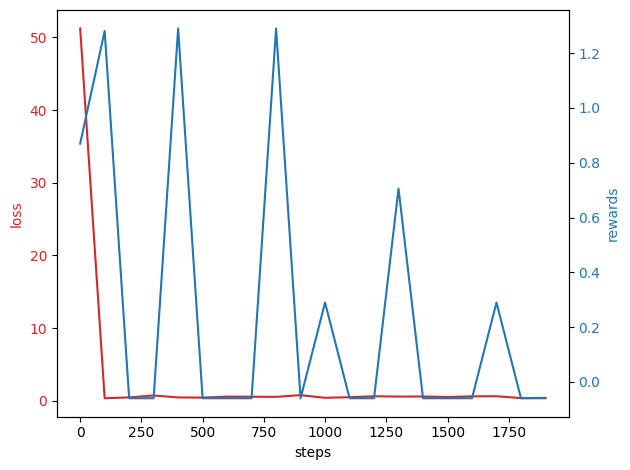

In [12]:
plot_training(loss, rewards, num_steps, 100)

### Common collect driver

In [11]:
num_steps = 20000
collect_driver, replay_buffer = get_cd_and_rb(train_env, agent, dataset_size, train_episodes_per_iteration)

In [ ]:
wandb.init(config=config)

In [ ]:
loss, observations, rewards = train(
    agent, train_env, test_env, collect_driver, replay_buffer, 
    steps = num_steps, use_wandb=True, eval_interval=100)

In [17]:
tf_policy_saver.save(policy_dir)

/Users/ellkrauze/projects/gc-ml/gc-ml-env/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:475: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


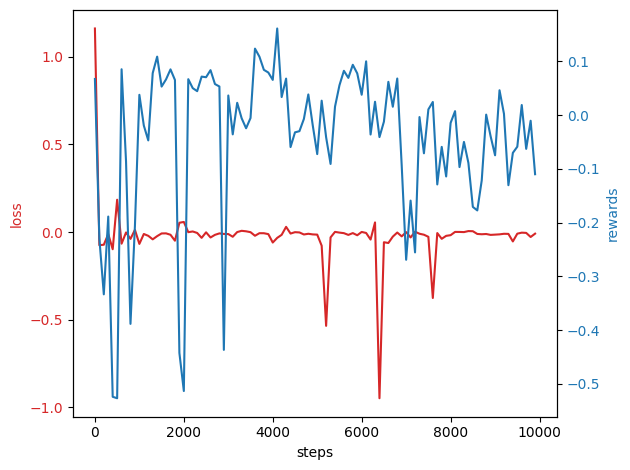

In [18]:
plot_training(loss, rewards, num_steps, 100)

## Test

In [ ]:
# wandb.init(job_type=policy_name)

In [7]:
wandb.init()

wandb: Currently logged in as: valeriia-sakovskaia (cold-machines). Use `wandb login --relogin` to force relogin


In [6]:
eval_env = get_tf_env(name="ext_avrora_32", args=env_args)
# env = test_env
env = eval_env
num_episodes = 300

# saved_policies = ["random_policy", "h2_policy", "avrora32_policy"]
saved_policies = ["avrora32_policy"]

for policy_name in saved_policies:
    wandb.init(name=policy_name)
    policy = tf.saved_model.load(policy_name)
    
    total_return = 0.0
    env.reset()
    # default_state = get_env_state(environment)
    
    for episode in range(num_episodes):
        time_step = env.reset()
        episode_return = 0.0
        action_step = policy.action(time_step)
        time_step = env.step(action_step.action)
        obs = time_step.observation.numpy()[0]
        rwd = time_step.reward.numpy()[0]
        episode_return += time_step.reward

        wandb.log({"episode": episode, "goal": obs[2]})
        # total_return += episode_return / i
    
    # if print_info: print("default:", default_state, "current:", get_env_state(environment))
    # avg_return = total_return / num_episodes
    # avg_return = avg_return.numpy()[0]

    avg_return = compute_avg_return_episodic(eval_env, policy, 100)
    print(f"[{policy_name}] average return: {avg_return}")
    wandb.log({"avg_return_eval": avg_return, "policy_name": policy_name})
    
    avg_return = compute_avg_return_episodic(test_env, policy, 100)
    print(f"[{policy_name}] average return: {avg_return}")
    wandb.log({"avg_return_test": avg_return, "policy_name": policy_name})

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: ext_avrora_32 (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16, 'step': 3}, 'ParallelGCThreads': {'min': 4, 'max': 24, 'step': 4}},
 Env. default state: [13, 4, 0.00559, -56730.0, -283648.0, 11.7, 177.0, 173.952, 34.8, 4724.0],
 Env. default goal value: 0.00559,



wandb: Currently logged in as: valeriia-sakovskaia (cold-machines). Use `wandb login --relogin` to force relogin


[avrora32_policy] average return: 0.25961586833000183
[avrora32_policy] average return: -0.0028855083510279655


<bound method TFEnvironment.observation_spec of <tf_agents.environments.tf_py_environment.TFPyEnvironment object at 0x173a2b2b0>>

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [11]:
random_policy = tf.saved_model.load("random_policy")
episode_return = 0.0
i = 0
time_step = test_env.reset()
action_step = random_policy.action(time_step)
time_step = test_env.step(action_step.action)
obs = time_step.observation.numpy()[0]

In [14]:
obs[2]

0.1788

In [19]:
def test(env, policy, patience: int=50, verbose: bool=False, num_flags: int=2):
    i = 0
    _observations = np.array([])
    _actions = np.array([])
    
    time_step = env.reset()
    default_state = get_env_state(env)
    
    while not time_step.is_last():
        if i >= patience:
            break
        
        _observations = np.append(_observations, time_step.observation.numpy().squeeze()[:num_flags])
        
        action_step = policy.action(time_step)
        time_step = env.step(action_step.action)
        
        _actions = np.append(_actions, action_step.action.numpy()[0])

        i += 1
        
    if verbose:
        print("start:", *default_state, 
          "recommendation:", *get_env_state(env))
    
    return _observations, _actions

In [20]:
# observations = np.array([])
# actions = np.array([])
observations = []
actions = []
# flags_num = 2
flags_num = 10
num_episodes = 1000
# num_episodes = 1
envs = [*batched_env.envs] # , JVMEnv(bm_name="h2", **env_args)

print(f"Getting {num_episodes * len(envs)} samples...")

for env in envs:
    # print(env._bm)
    env = tf_py_environment.TFPyEnvironment(env)
    
    for _ in range(num_episodes):
        # Get the agent's next recommendation (patience=1)
        # based on the input state.
        obs, act = test(env, saved_policy, patience=1, verbose=False, num_flags=flags_num)
        observations.append(obs)
        actions.append(*act)
        # observations = np.vstack([observations, obs])
        # actions = np.vstack([actions, act])
    
# print("Test environments")
# obs, act = test(test_env, agent.policy, patience=1)
# observations.append(obs)
# actions.append(act)

Getting 10000 samples...


In [21]:
df = pd.DataFrame(data={
    "observations": observations,
    "actions": actions,
})
# df[["MaxTenuringThreshold", "ParallelGCThreads"]] = df["observations"].apply(pd.Series)
# df = df.drop(columns=["observations"])
display(df[:10])

,observations,actions
0,"[1.0, 4.0, 0.009979999624192715, 0.99177300930...",0.0
1,"[1.0, 8.0, 0.008779999800026417, 0.99178922176...",0.0
2,"[7.0, 4.0, 0.010130000300705433, 0.99206787347...",2.0
3,"[7.0, 16.0, 0.008170000277459621, 0.9922335147...",0.0
4,"[7.0, 8.0, 0.008430000394582748, 0.99230021238...",0.0
5,"[4.0, 16.0, 0.009730000048875809, 0.9927516579...",0.0
6,"[1.0, 24.0, 0.012539999559521675, 0.9924421310...",2.0
7,"[4.0, 12.0, 0.007439999841153622, 0.9931966662...",0.0
8,"[13.0, 20.0, 0.010130000300705433, 0.992835521...",2.0
9,"[13.0, 24.0, 0.011189999990165234, 0.992899894...",2.0


Here we transform the input data X by PCA into Xt. We consider only the first two columns, which contain the most information, and plot it in two dimensional. 

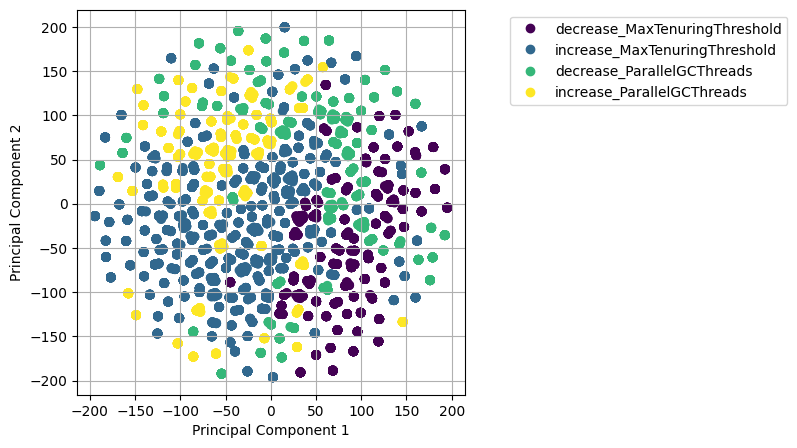

In [43]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

fig = plt.figure(figsize=(5, 5))
X, y = df["observations"].apply(pd.Series), df["actions"]

X = StandardScaler().fit_transform(X) # normalizing the features

Xt = TSNE().fit_transform(X)

plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)

# plot = plt.scatter(X[0], X[1], c=y)
target_names = [
    "decrease_MaxTenuringThreshold", 
    "increase_MaxTenuringThreshold", 
    "decrease_ParallelGCThreads", 
    "increase_ParallelGCThreads"
]
# plt.legend(handles=plot.legend_elements()[0], labels=target_names)
plt.legend(
    handles=plot.legend_elements()[0], labels=target_names,  bbox_to_anchor=(1.1, 1.0))
# plt.xlabel("MaxTenuringThreshold")
# plt.ylabel("ParallelGCThreads")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

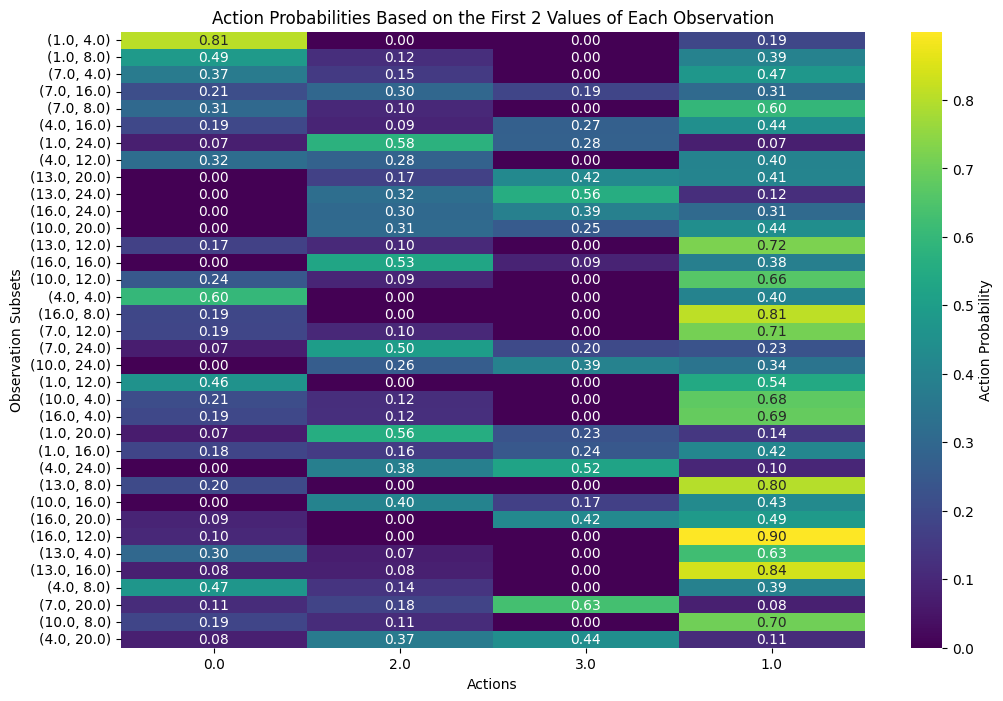

In [26]:
# Assuming your DataFrame is named df
# If it's not already, convert the 'observations' column to a NumPy array
df['observations'] = df['observations'].apply(np.array)

# Extract the first two values of each observation
df['observation_subset'] = df['observations'].apply(lambda x: tuple(x[:2]))

# Extract unique subsets and actions from the DataFrame
unique_subsets = df['observation_subset'].unique()
unique_actions = df['actions'].unique()

# Create an empty matrix to store action probabilities for each subset
action_probabilities = np.zeros((len(unique_subsets), len(unique_actions)))

# Populate the matrix with action probabilities
for i, subset in enumerate(unique_subsets):
    subset_rows = df['observation_subset'].apply(lambda x: x == subset)
    subset_actions = df.loc[subset_rows, 'actions'].values
    for j, action in enumerate(unique_actions):
        action_probabilities[i, j] = np.mean(subset_actions == action)

# Create a DataFrame for the action probabilities matrix
heatmap_data = pd.DataFrame(action_probabilities, columns=unique_actions, index=unique_subsets)

# Create a heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".2f", cbar_kws={'label': 'Action Probability'})
plt.title('Action Probabilities Based on the First 2 Values of Each Observation')
plt.xlabel('Actions')
plt.ylabel('Observation Subsets')
plt.show()

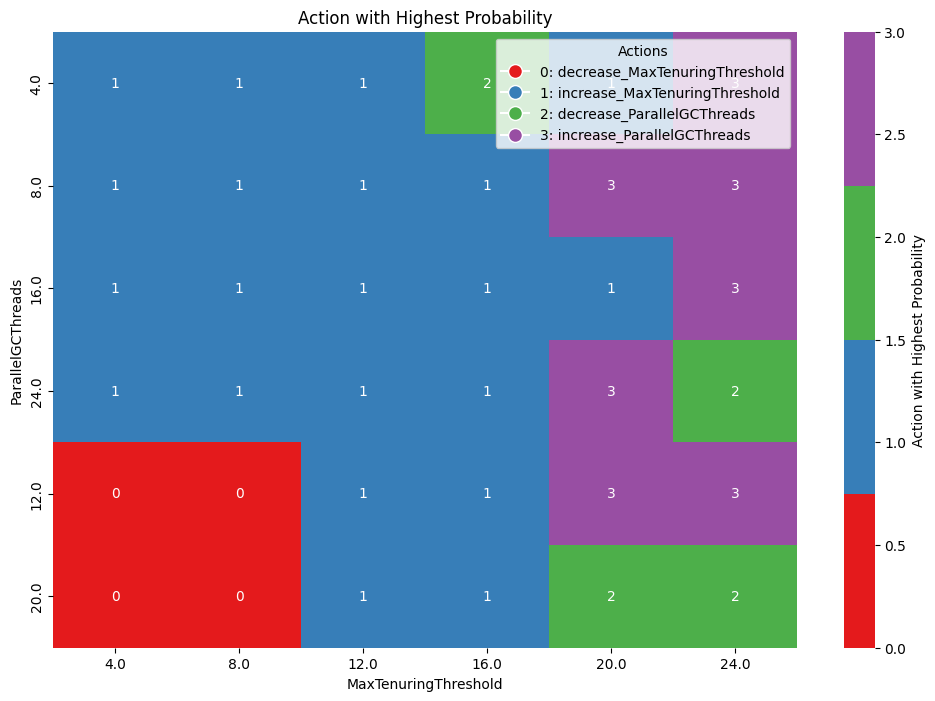

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# If it's not already, convert the 'observations' column to a NumPy array
df['observations'] = df['observations'].apply(np.array)

# Extract the first two values of each observation
df[['observation_x', 'observation_y']] = df['observations'].apply(lambda x: pd.Series(x[:2]))

# Map action labels to numerical values (0, 1, 2, 3)
action_mapping = {0: 0, 1: 1, 2: 2, 3: 3}  # Add more if needed
df['actions_mapped'] = df['actions'].map(action_mapping)

# Group by 'observation_x' and 'observation_y' and find the action with the highest probability
max_prob_actions = df.groupby(['observation_x', 'observation_y'])['actions_mapped'].agg(lambda x: x.value_counts().idxmax())

# Create a DataFrame for the heatmap
heatmap_data = max_prob_actions.unstack()

# Map numeric action labels to target names
target_names = [
    "decrease_MaxTenuringThreshold", 
    "increase_MaxTenuringThreshold", 
    "decrease_ParallelGCThreads", 
    "increase_ParallelGCThreads"
]
heatmap_data.replace(action_mapping, inplace=True)
heatmap_data.replace({v: k for k, v in enumerate(target_names)}, inplace=True)

# Create a custom color palette for actions
palette = sns.color_palette("Set1", n_colors=len(action_mapping))

# Create a heatmap using seaborn and specify the color palette
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    heatmap_data, cmap=palette, 
    annot=True, fmt=".0f", 
    cbar_kws={'label': 'Action with Highest Probability'},
    yticklabels=df['observation_y'].unique()[::-1]  # Invert y-axis labels
)

# Invert y-axis using Matplotlib Axes method
ax.invert_yaxis()

# Add a legend
legend_labels = [f"{i}: {name}" for i, name in enumerate(target_names)]
legend_colors = sns.color_palette("Set1", n_colors=len(target_names))
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]
plt.legend(legend_handles, legend_labels, title="Actions", loc='upper right')

plt.title('Action with Highest Probability')
plt.xlabel('MaxTenuringThreshold')
plt.ylabel('ParallelGCThreads')
plt.show()


In [63]:
import random 

random.randrange(4, 24, 4)

12

In [16]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# fig = plt.figure(figsize=(5, 5))
X, y = df["observations"].apply(pd.Series), df["actions"]

X = StandardScaler().fit_transform(X) # normalizing the features

# pca = PCA()
# Xt = pca.fit_transform(X)

# plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
# plot = plt.scatter(X[0], X[1], c=y)
# plot = plt.scatter(X[:, 0], X[:, 1], c=y)
target_names = [
    "decrease_MaxTenuringThreshold", 
    "increase_MaxTenuringThreshold", 
    "decrease_ParallelGCThreads", 
    "increase_ParallelGCThreads"
]

fig = px.scatter_3d(
    x=X[:, 0], y=X[:, 1], z=y, color=y, opacity=0.8,
    )
fig.show()

# plt.legend(
#     handles=plot.legend_elements()[0], labels=target_names,  bbox_to_anchor=(1.1, 1.0))
# plt.xlabel("MaxTenuringThreshold")
# plt.ylabel("ParallelGCThreads")
# # plt.xlabel("Principal Component 1")
# # plt.ylabel("Principal Component 2")
# plt.grid()
# plt.show()

In [16]:
print(compute_avg_return_episodic(test_env, agent.policy, num_episodes=50))
# print(compute_avg_return_episodic(test_env_2, agent.policy, num_episodes=50))

0.011308405


### PCA Visualization

In [ ]:
# Save the progress.
train_checkpointer.save(global_step)
tf_policy_saver.save(policy_dir)

In [12]:
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()
saved_policy = tf.saved_model.load(policy_dir)

In [13]:
test_env = get_tf_env("test", env_args)
test_env_copy = get_tf_env("test", env_args)

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: test (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.57],
 Env. default goal value: 0.57,

Successfully initialized a JVM Environment!
 JDK: jdk-11.0.20.1.jdk/bin,
 Benchmark: test (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.57],
 Env. default goal value: 0.57,



In [14]:
compute_avg_return_episodic(test_env, agent.policy, num_episodes=50)

100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


-0.122350894

In [30]:
num_steps=5000
_loss_test, _, _rewards_test = train(
    agent, test_env, test_env, replay_buffer, collect_driver, steps = num_steps, eval_interval=100)

  0%|          | 3/5000 [00:06<2:29:07,  1.79s/it]

step = 0: loss = -0.08275873959064484, reward = 0.15449999272823334


  2%|▏         | 103/5000 [00:20<1:01:50,  1.32it/s]

step = 100: loss = 0.027595680207014084, reward = 0.15449999272823334


  4%|▍         | 203/5000 [00:33<1:00:14,  1.33it/s]

step = 200: loss = 0.01597478985786438, reward = 0.15449999272823334


  6%|▌         | 303/5000 [00:47<59:38,  1.31it/s]  

step = 300: loss = 0.07849355041980743, reward = 0.15449999272823334


  8%|▊         | 403/5000 [01:00<57:59,  1.32it/s]  

step = 400: loss = 0.07866153120994568, reward = 0.15449999272823334


 10%|█         | 503/5000 [01:13<56:36,  1.32it/s]  

step = 500: loss = 0.0788775384426117, reward = 0.15449999272823334


 12%|█▏        | 603/5000 [01:27<55:18,  1.33it/s]  

step = 600: loss = 0.03862088546156883, reward = 0.15449999272823334


 14%|█▍        | 703/5000 [01:40<54:29,  1.31it/s]  

step = 700: loss = 0.020812472328543663, reward = 0.15449999272823334


 16%|█▌        | 803/5000 [01:54<52:54,  1.32it/s]  

step = 800: loss = 0.030953237786889076, reward = 0.15449999272823334


 18%|█▊        | 903/5000 [02:07<51:42,  1.32it/s]  

step = 900: loss = -0.07765475660562515, reward = 0.15449999272823334


 20%|██        | 1003/5000 [02:21<53:21,  1.25it/s]  

step = 1000: loss = 0.06647924333810806, reward = 0.15449999272823334


 22%|██▏       | 1103/5000 [02:34<50:21,  1.29it/s]  

step = 1100: loss = 0.07829032093286514, reward = 0.15449999272823334


 24%|██▍       | 1203/5000 [02:48<47:26,  1.33it/s]  

step = 1200: loss = 0.07940496504306793, reward = 0.15449999272823334


 26%|██▌       | 1303/5000 [03:01<45:59,  1.34it/s]  

step = 1300: loss = 0.03141622990369797, reward = 0.15449999272823334


 28%|██▊       | 1403/5000 [03:14<44:50,  1.34it/s]  

step = 1400: loss = 0.055435724556446075, reward = 0.15449999272823334


 30%|███       | 1503/5000 [03:27<43:22,  1.34it/s]  

step = 1500: loss = 0.06776073575019836, reward = 0.15449999272823334


 32%|███▏      | 1603/5000 [03:41<42:07,  1.34it/s]

step = 1600: loss = 0.0697450116276741, reward = 0.15449999272823334


 34%|███▍      | 1703/5000 [03:54<43:14,  1.27it/s]  

step = 1700: loss = 0.0339801087975502, reward = 0.15449999272823334


 36%|███▌      | 1803/5000 [04:08<41:34,  1.28it/s]

step = 1800: loss = 0.06431885808706284, reward = 0.15449999272823334


 38%|███▊      | 1903/5000 [04:22<41:33,  1.24it/s]

step = 1900: loss = 0.0638260543346405, reward = 0.15449999272823334


 40%|████      | 2003/5000 [04:36<39:58,  1.25it/s]

step = 2000: loss = -0.06647807359695435, reward = 0.15449999272823334


 42%|████▏     | 2103/5000 [04:50<37:27,  1.29it/s]

step = 2100: loss = 0.06989308446645737, reward = 0.15449999272823334


 44%|████▍     | 2203/5000 [05:03<35:25,  1.32it/s]

step = 2200: loss = 0.07144589722156525, reward = 0.15449999272823334


 46%|████▌     | 2303/5000 [05:16<34:00,  1.32it/s]

step = 2300: loss = 0.017992911860346794, reward = 0.15449999272823334


 48%|████▊     | 2403/5000 [05:30<32:49,  1.32it/s]

step = 2400: loss = 0.06617488712072372, reward = 0.15449999272823334


 50%|█████     | 2503/5000 [05:43<31:27,  1.32it/s]

step = 2500: loss = 0.06551690399646759, reward = 0.15449999272823334


 52%|█████▏    | 2603/5000 [05:57<30:18,  1.32it/s]

step = 2600: loss = 0.06771502643823624, reward = 0.15449999272823334


 54%|█████▍    | 2703/5000 [06:10<29:36,  1.29it/s]

step = 2700: loss = 0.01253617275506258, reward = 0.15449999272823334


 56%|█████▌    | 2803/5000 [06:24<27:46,  1.32it/s]

step = 2800: loss = 0.0662756860256195, reward = 0.15449999272823334


 58%|█████▊    | 2903/5000 [06:37<26:43,  1.31it/s]

step = 2900: loss = 0.06570452451705933, reward = 0.15449999272823334


 60%|██████    | 3003/5000 [06:50<25:14,  1.32it/s]

step = 3000: loss = 0.0676717460155487, reward = 0.15449999272823334


 62%|██████▏   | 3103/5000 [07:04<23:52,  1.32it/s]

step = 3100: loss = 0.015165931545197964, reward = 0.15449999272823334


 64%|██████▍   | 3203/5000 [07:17<22:37,  1.32it/s]

step = 3200: loss = 0.06071428209543228, reward = 0.15449999272823334


 66%|██████▌   | 3303/5000 [07:31<21:27,  1.32it/s]

step = 3300: loss = 0.05883081629872322, reward = 0.15449999272823334


 68%|██████▊   | 3403/5000 [07:44<20:11,  1.32it/s]

step = 3400: loss = 0.05168354883790016, reward = 0.15449999272823334


 70%|███████   | 3503/5000 [07:57<18:50,  1.32it/s]

step = 3500: loss = 0.017617255449295044, reward = 0.15449999272823334


 72%|███████▏  | 3603/5000 [08:11<17:45,  1.31it/s]

step = 3600: loss = 0.054672833532094955, reward = 0.15449999272823334


 74%|███████▍  | 3703/5000 [08:24<16:22,  1.32it/s]

step = 3700: loss = 0.07289864867925644, reward = 0.15449999272823334


 76%|███████▌  | 3803/5000 [08:38<15:06,  1.32it/s]

step = 3800: loss = 0.06126633659005165, reward = 0.15449999272823334


 78%|███████▊  | 3903/5000 [08:51<13:51,  1.32it/s]

step = 3900: loss = 0.012533322907984257, reward = 0.15449999272823334


 80%|████████  | 4003/5000 [09:05<12:33,  1.32it/s]

step = 4000: loss = 0.0729455053806305, reward = 0.15449999272823334


 82%|████████▏ | 4103/5000 [09:18<11:23,  1.31it/s]

step = 4100: loss = 0.060445066541433334, reward = 0.15449999272823334


 84%|████████▍ | 4203/5000 [09:31<10:01,  1.33it/s]

step = 4200: loss = -0.08400257676839828, reward = 0.15449999272823334


 86%|████████▌ | 4303/5000 [09:45<08:49,  1.32it/s]

step = 4300: loss = 0.0662526786327362, reward = 0.15449999272823334


 88%|████████▊ | 4403/5000 [09:58<07:31,  1.32it/s]

step = 4400: loss = 0.0637577548623085, reward = 0.15449999272823334


 90%|█████████ | 4503/5000 [10:12<06:38,  1.25it/s]

step = 4500: loss = 0.05468904227018356, reward = 0.15449999272823334


 92%|█████████▏| 4603/5000 [10:26<05:05,  1.30it/s]

step = 4600: loss = 0.010259442031383514, reward = 0.15449999272823334


 94%|█████████▍| 4703/5000 [10:39<03:45,  1.32it/s]

step = 4700: loss = 0.008904497139155865, reward = 0.15449999272823334


 96%|█████████▌| 4803/5000 [10:52<02:29,  1.31it/s]

step = 4800: loss = -0.07732591032981873, reward = 0.15449999272823334


 98%|█████████▊| 4903/5000 [11:06<01:13,  1.31it/s]

step = 4900: loss = 0.06026251241564751, reward = 0.15449999272823334


100%|██████████| 5000/5000 [11:12<00:00,  7.43it/s]


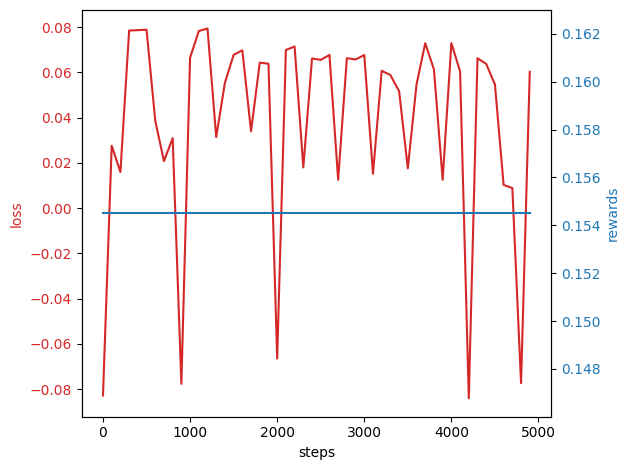

In [31]:
plot_training(_loss_test, _rewards_test, num_steps, 100)

In [ ]:
compute_avg_return_episodic(test_env, agent.policy, num_episodes=50)

Save to checkpoint.

In [ ]:
# train_checkpointer.save(global_step)

# WandB

In [9]:
# Set this to True when you want to run hyperparameter tuning
hyperparameter_tuning = True

def main():
    run = wandb.init(config = config)
    
    agent_args = {
        "q_network":            get_q_net(action_spec, fc_layer_params),
        "optimizer":            tf.compat.v1.train.AdamOptimizer(
                                    learning_rate=run.config.learning_rate),
        "n_step_update":        n_step_update, 
        "td_errors_loss_fn":    tf.keras.losses.MeanSquaredError(),
        "epsilon_greedy":       run.config.epsilon_greedy,
        "target_update_period": run.config.target_update_period,
        "gamma":                run.config.gamma,
        "gradient_clipping":    1,
        "train_step_counter":   tf.compat.v1.train.get_or_create_global_step(),
    }
        
    _agent = dqn_agent.DqnAgent(
        time_step_spec,
        action_spec,
        **agent_args
    )

    loss, _, rewards = train(_agent, train_env, train_env_copy, steps = 5000, use_wandb = True)
    
    wandb.log({'avg_loss': np.mean(loss), 'avg_reward': np.mean(rewards)})

    del _agent
    return

# Define sweep config
sweep_configuration = {
    'method': 'random',
    'name': 'rl_greed',
    "metric": {
        "name" : "avg_reward",
        "goal": "maximize"
    },
    "parameters" : {
        "learning_rate": {
            "min": 0.0001,
            "max": 0.01
        },
        "epsilon_greedy": {'values': [0.1, 0.3, 0.5, 0.7, 0.9]},
        "target_update_period": {'values': [1, 10, 100, 1000, 10000]},
        "gamma": {'values': [0.1, 0.3, 0.5, 0.7, 0.9]},
    },
    'run_cap' : 32
}

if hyperparameter_tuning:
    ! export WANDB_NOTEBOOK_NAME="main.ipynb"
    # Initialize sweep by passing in config. (Optional) Provide a name of the project.
    sweep_id = wandb.sweep(sweep=sweep_configuration, project=PROJECT_NAME,)

    # Start sweep job.
    wandb.agent(sweep_id, function=main)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: srh8mikx
Sweep URL: https://wandb.ai/cold-machines/Reinforcement%20Learning%20%28DQN%29%20-%20JVM-GC/sweeps/srh8mikx


wandb: Agent Starting Run: 86wuplng with config:
wandb: 	epsilon_greedy: 0.7
wandb: 	gamma: 0.1
wandb: 	learning_rate: 0.009081865474555018
wandb: 	target_update_period: 100
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: valeriia-sakovskaia (cold-machines). Use `wandb login --relogin` to force relogin


  0%|          | 0/5000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
  2%|▏         | 101/5000 [00:16<18:44,  4.36it/s]

step = 100: loss = 0.051988594233989716, reward = -0.05968308076262474


  4%|▍         | 201/5000 [00:32<17:56,  4.46it/s]

step = 200: loss = 0.04959993064403534, reward = -0.05968308076262474


  6%|▌         | 301/5000 [00:48<17:17,  4.53it/s]

step = 300: loss = 0.05310416966676712, reward = -0.05968308076262474


  8%|▊         | 401/5000 [01:04<21:05,  3.64it/s]

step = 400: loss = 0.07190939784049988, reward = -0.05968308076262474


 10%|█         | 501/5000 [01:20<16:40,  4.50it/s]

step = 500: loss = 0.06140190362930298, reward = -0.05968308076262474


 12%|█▏        | 601/5000 [01:36<16:26,  4.46it/s]

step = 600: loss = 0.07814410328865051, reward = -0.05968308076262474


 14%|█▍        | 701/5000 [01:53<16:30,  4.34it/s]

step = 700: loss = 0.05395403504371643, reward = -0.05968308076262474


 16%|█▌        | 801/5000 [02:08<15:39,  4.47it/s]

step = 800: loss = 0.05778862535953522, reward = -0.05968308076262474


 18%|█▊        | 901/5000 [02:25<14:59,  4.56it/s]

step = 900: loss = 0.05692460760474205, reward = -0.05968308076262474


 20%|██        | 1001/5000 [02:41<15:17,  4.36it/s]

step = 1000: loss = 0.059485163539648056, reward = -0.05968308076262474


 22%|██▏       | 1101/5000 [02:57<14:36,  4.45it/s]

step = 1100: loss = 0.07164233177900314, reward = -0.05968308076262474


 24%|██▍       | 1201/5000 [03:14<14:20,  4.41it/s]

step = 1200: loss = 0.04963871091604233, reward = -0.05968308076262474


 26%|██▌       | 1301/5000 [03:30<14:23,  4.28it/s]

step = 1300: loss = 0.05595877766609192, reward = -0.05968308076262474


 28%|██▊       | 1401/5000 [03:46<13:25,  4.47it/s]

step = 1400: loss = 0.05879542976617813, reward = -0.05968308076262474


 30%|███       | 1501/5000 [04:02<12:52,  4.53it/s]

step = 1500: loss = 0.06716286391019821, reward = -0.05968308076262474


 32%|███▏      | 1601/5000 [04:18<13:14,  4.28it/s]

step = 1600: loss = 0.05800986662507057, reward = -0.05968308076262474


 34%|███▍      | 1701/5000 [04:35<12:29,  4.40it/s]

step = 1700: loss = 0.06368903815746307, reward = -0.05968308076262474


 36%|███▌      | 1801/5000 [04:51<12:38,  4.22it/s]

step = 1800: loss = 0.05840213596820831, reward = -0.05968308076262474


 38%|███▊      | 1901/5000 [05:07<11:47,  4.38it/s]

step = 1900: loss = 0.06790091097354889, reward = -0.05968308076262474


 40%|████      | 2001/5000 [05:24<11:03,  4.52it/s]

step = 2000: loss = 0.05456307530403137, reward = -0.05968308076262474


 42%|████▏     | 2101/5000 [05:39<10:43,  4.51it/s]

step = 2100: loss = 0.05199477821588516, reward = -0.05968308076262474


 44%|████▍     | 2201/5000 [05:56<10:51,  4.30it/s]

step = 2200: loss = 0.046316057443618774, reward = -0.05968308076262474


 46%|████▌     | 2301/5000 [06:12<09:51,  4.56it/s]

step = 2300: loss = 0.0451720654964447, reward = -0.05968308076262474


 48%|████▊     | 2401/5000 [06:28<09:59,  4.34it/s]

step = 2400: loss = 0.05063679814338684, reward = -0.05968308076262474


 50%|█████     | 2501/5000 [06:44<09:13,  4.51it/s]

step = 2500: loss = 0.05682305246591568, reward = -0.05968308076262474


 52%|█████▏    | 2601/5000 [07:01<08:57,  4.46it/s]

step = 2600: loss = 0.057316817343235016, reward = -0.05968308076262474


 54%|█████▍    | 2701/5000 [07:17<08:40,  4.42it/s]

step = 2700: loss = 0.06233186647295952, reward = -0.05968308076262474


 56%|█████▌    | 2801/5000 [07:34<08:08,  4.50it/s]

step = 2800: loss = 0.030263567343354225, reward = -0.05968308076262474


 58%|█████▊    | 2901/5000 [07:49<07:45,  4.51it/s]

step = 2900: loss = 0.12275780737400055, reward = -0.05968308076262474


 60%|██████    | 3001/5000 [08:06<07:35,  4.39it/s]

step = 3000: loss = 0.0640171468257904, reward = -0.05968308076262474


 62%|██████▏   | 3101/5000 [08:22<07:06,  4.45it/s]

step = 3100: loss = 0.06743437051773071, reward = -0.05968308076262474


 64%|██████▍   | 3201/5000 [08:39<07:00,  4.27it/s]

step = 3200: loss = 0.07279805094003677, reward = -0.05968308076262474


 66%|██████▌   | 3301/5000 [08:55<06:22,  4.45it/s]

step = 3300: loss = 0.03942070156335831, reward = -0.05968308076262474


 68%|██████▊   | 3401/5000 [09:12<06:25,  4.14it/s]

step = 3400: loss = 0.06413926929235458, reward = -0.05968308076262474


 70%|███████   | 3501/5000 [09:27<05:42,  4.38it/s]

step = 3500: loss = 0.04303019493818283, reward = -0.05968308076262474


 72%|███████▏  | 3601/5000 [09:43<05:13,  4.46it/s]

step = 3600: loss = 0.0326034352183342, reward = -0.05968308076262474


 74%|███████▍  | 3701/5000 [10:00<04:56,  4.38it/s]

step = 3700: loss = 0.06070145219564438, reward = -0.05968308076262474


 76%|███████▌  | 3801/5000 [10:16<04:34,  4.37it/s]

step = 3800: loss = 0.05568353831768036, reward = -0.05968308076262474


 78%|███████▊  | 3901/5000 [10:33<04:09,  4.40it/s]

step = 3900: loss = 0.0671439915895462, reward = -0.05968308076262474


 80%|████████  | 4001/5000 [10:49<03:42,  4.49it/s]

step = 4000: loss = 0.07973361760377884, reward = -0.05968308076262474


 82%|████████▏ | 4101/5000 [11:06<03:38,  4.11it/s]

step = 4100: loss = 0.05744113028049469, reward = -0.05968308076262474


 84%|████████▍ | 4201/5000 [11:22<03:00,  4.44it/s]

step = 4200: loss = 0.04437218979001045, reward = -0.05968308076262474


 86%|████████▌ | 4301/5000 [11:37<02:34,  4.51it/s]

step = 4300: loss = 0.06655722111463547, reward = -0.05968308076262474


 88%|████████▊ | 4401/5000 [11:55<02:13,  4.49it/s]

step = 4400: loss = 0.054657574743032455, reward = -0.05968308076262474


 90%|█████████ | 4501/5000 [12:10<01:51,  4.49it/s]

step = 4500: loss = 0.05559392273426056, reward = -0.05968308076262474


 92%|█████████▏| 4601/5000 [12:27<01:32,  4.31it/s]

step = 4600: loss = 0.062225304543972015, reward = -0.05968308076262474


 94%|█████████▎| 4678/5000 [12:39<00:49,  6.51it/s]

### Restore checkpoint

In [ ]:
def test(policy, test_env, num_episodes: int=10000):
    rewards = []
    log_interval = 100
    time_step = test_env.reset()
    total_return = 0.0
    for i in tqdm(range(10000)):
        policy_state = policy.action(time_step)
        time_step = test_env.step(policy_state.action)
        reward = time_step.reward.numpy()[0]
        total_return += reward # Calculate a sum of rewards

        if i % log_interval == 0:
            # avg_return = compute_avg_return(train_env_copy, agent.policy, 10)
            avg_return = total_return / eval_interval
            print('step = {0}: Average reward = {1:.5f}'.format(step, avg_return))
            rewards.append(avg_return)
            total_return = 0.0 # reset
    return rewards

# test(agent.policy, test_env)

# Episodic Memory

In [70]:
from util import episodic_memory
from sklearn.mixture import GaussianMixture

def embedding_similarity(x1, x2):
    assert x1.shape[0] == x2.shape[0]
    epsilon = 1e-6

    # Inner product between the embeddings in x1
    # and the embeddings in x2.
    s = np.sum(x1 * x2, axis=-1)

    s = s / (np.linalg.norm(x1, axis=-1) * np.linalg.norm(x2, axis=-1) + epsilon)
    return 0.5 * (s + 1.0)


In [66]:
observations = replay_buffer.gather_all()[1].numpy().squeeze()
actions = replay_buffer.gather_all()[2].numpy().squeeze()
size = 15

memory_buffer = np.array([[*observations[i], actions[i]] for i in range(size)])

In [82]:
memory_buffer.squeeze().shape

(15, 3)

In [76]:
gm = GaussianMixture(n_components=memory_buffer.shape[1])

In [77]:
gm.fit(memory_buffer)

GaussianMixture(n_components=3)

In [84]:
gm.predict_proba([[7, 12, 0]])

array([[0.00000000e+00, 9.99999917e-01, 8.31505676e-08]])

In [62]:
df = pd.read_csv(f"avrora_synthetic_saved_states.csv")
print("df size:", len(df))
states  = {}
size = 15 
# replay_buffer.capacity
for i in range(size):
    states [i] = {"args": [df["MaxTenuringThreshold"].values[i], df["ParallelGCThreads"].values[i]], "goal": df["Average GC Pause"].values[i]}

# memory_buffer = np.array([states[i]["args"] for i in states.keys()])
memory_buffer = np.array([[*observations[i], actions[i]] for i in range(size)])
print(memory_buffer)

df size: 36
[[ 4 24  3]
 [ 4 24  1]
 [ 7 24  2]
 [ 7 20  2]
 [ 7 16  3]
 [ 7 20  0]
 [ 4 20  3]
 [ 4 24  2]
 [ 4 20  2]
 [ 4 16  2]
 [ 4 12  1]
 [ 7 12  0]
 [ 4 12  1]
 [ 7 12  3]
 [ 7 16  2]]


In [92]:
perf_states = {}
perf_states[0] = {"args": [7, 12], "goal": 0.47, "count": 1} 
saved_states = [perf_states[i]["args"] for i in perf_states.keys()]
flags = [7, 12]
if flags in saved_states:
    for i in perf_states.keys():
        """ 
        If current state is stored in a cache,
        update the state goal value.
        """
        if flags == perf_states[i]["args"]:
            goal = perf_states[i]["goal"]
            perf_states[i]["count"] += 1

print(perf_states)

{0: {'args': [7, 12], 'goal': 0.47, 'count': 2}}


In [97]:
for i in perf_states.keys():
    if [7, 12] == perf_states[i]["args"]:
        print(perf_states[i]["count"])

2


In [15]:
(1 + 0.01)**(-1/4)

0.9975155087566253

In [63]:
observation = np.array([[7, 12, 3]] * size)
similarity = embedding_similarity(observation, memory_buffer[:size])
similarity

array([0.96638056, 0.96084794, 0.98113075, 0.98760397, 0.99632883,
       0.97980966, 0.97269349, 0.9640097 , 0.97034901, 0.97857303,
       0.98519848, 0.98873447, 0.98519848, 1.        , 0.99432438])

In [48]:
traj

Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[ 7, 12]])>,
 'policy_info': (),
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})

In [47]:
import math

math.log(0.00001)

-11.512925464970229

In [7]:
observations = replay_buffer.gather_all()[1].numpy().squeeze()
print(len(observations))
# for i in range(100):
#     print(f"[{i}] {observations[i]}")

print(f"[{0}] {observations[0]}")
print(f"[{10}] {observations[10]}")
print(f"[{15}] {observations[15]}")
print(f"[{2}] {observations[2]}")
print(f"[{4}] {observations[4]}")

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


10000
[0] [ 7 12]
[10] [ 7 16]
[15] [4 8]
[2] [10  8]
[4] [ 4 12]


In [10]:
observation_shape = [2]
memory = episodic_memory.EpisodicMemory(
    observation_shape=observation_shape,
    observation_compare_fn=embedding_similarity,
    capacity=150)

memory.add(observation=observations[0], info=dict())
memory.add(observation=observations[10], info=dict())
memory.add(observation=observations[15], info=dict())
memory.add(observation=observations[2], info=dict())
memory.add(observation=observations[4], info=dict())

In [35]:
similarities = memory.similarity(observations[0])
print(similarities)

[1.         0.99556546 0.99941687 1.         1.        ]


0.4711529108389231

In [56]:
new_df = pd.read_csv(f"avrora_synthetic_saved_states.csv")
perf_states  = {}
flags = [7, 12]
def synthethic_run(flags):
    assert len(flags) == 2, "Amount of flags is not 2"
    row = new_df[((new_df["MaxTenuringThreshold"] == flags[0]) & (new_df["ParallelGCThreads"] == flags[1]))].values.squeeze()
    goal = row[2]
    return goal

synthethic_run(flags)

0.4711529108389231